In [1]:
import os
from functions import clean_word, lematize_word, stem_word, parsePDF


from collections import Counter
import pandas as pd
import numpy as np
import urllib
import requests

# plotting and wordcloud
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# NLTK
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('white')

In [2]:
# set file path and read words
data_path = '/Users/Gabi/PycharmProjects/mueller/data'
file_name = 'mueller_words.txt'
# open file with list of words
f = os.path.join(data_path, file_name)
with open(f, 'r') as openFile:
    mueller_words = openFile.readlines()

In [3]:
mueller_words = [word.strip("\n") for word in mueller_words]
# clean words
cleaned_words = [clean_word(x) for x in mueller_words]

In [4]:
cleaned_words = [x.replace('russian', 'russia') for x in cleaned_words]

In [5]:
len(cleaned_words)

100726

In [6]:
# lematize words
lemmas = [lematize_word(x) for x in cleaned_words if x]
# for ix, i in enumerate(cleaned_words):
#     if i!='':
#         print('index: {}, word: {}, lemma: {}'.format(ix, i, lematize_word(i)))

In [7]:
lemma_counts = Counter(lemmas)
print("top 10 words found in report", lemma_counts.most_common(20))

('top 10 words found in report', [(None, 2674), (u'president', 2335), ('russia', 1481), ('trump', 1470), ('campaign', 823), ('email', 813), ('cohen', 739), ('investigation', 690), ('justice', 654), (u'state', 647), (u'counsel', 640), ('meeting', 638), (u'say', 585), ('office', 579), ('flynn', 570), ('department', 563), ('corney', 546), ('mcgahn', 511), ('told', 496), (u'statement', 459)])


In [8]:
df_wordcounts = pd.DataFrame(list(lemma_counts.most_common(21)), columns=['words','freq'])
# remove None
df_wordcounts.drop(0, axis=0, inplace=True)
df_wordcounts

,words,freq
1,president,2335
2,russia,1481
3,trump,1470
4,campaign,823
5,email,813
6,cohen,739
7,investigation,690
8,justice,654
9,state,647
10,counsel,640


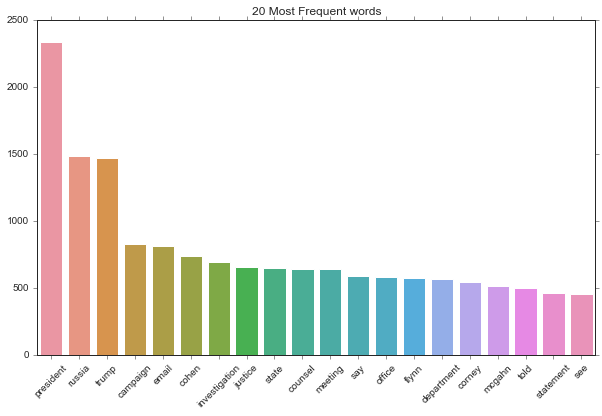

In [9]:
# create bar plot of top 20 words
fig, ax = plt.subplots(figsize = (10,6))
_ = sns.barplot(data = df_wordcounts, x = 'words', y = 'freq', ax = ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 45)
ax.set_title("20 Most Frequent words")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show(fig)

### WordClouds

In [10]:
# create wordcloud with specific settings
wordcloud = WordCloud(width = 512, height = 512, background_color='white', 
                      max_font_size=50, max_words=150)

In [11]:
# add words
wordcloud = wordcloud.generate_from_frequencies(df_wordcounts.set_index('words').freq)

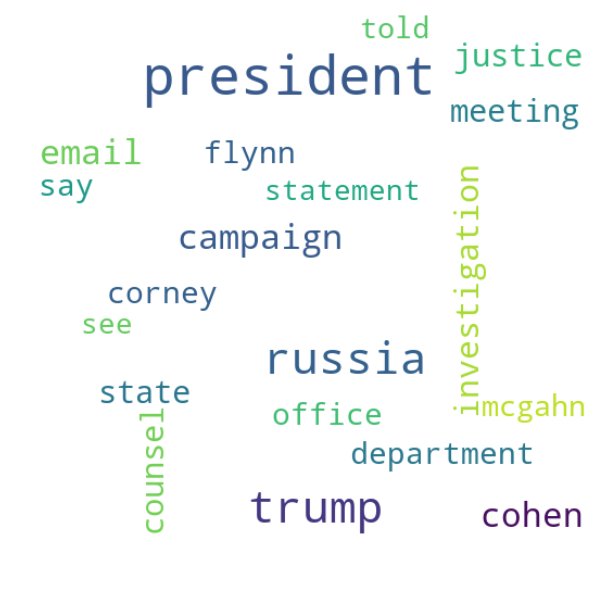

In [12]:
# plot words
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [13]:
# generate wordcloud with custom settings 
wordcloud = WordCloud(width = 512, height = 512, background_color='white', colormap=cm.coolwarm,
                      contour_width=10, contour_color='black',
                     max_font_size=70, max_words=150)

In [14]:
# convert jpg file to an array to use as shape for wordcloud
mueller_mask = np.array(Image.open("img/mueller_mask.jpeg"))
mueller_mask_2 = np.array(Image.open("img/mueller_mask5.jpg"))
mueller_mask_3 = np.array(Image.open("img/mask2.jpeg"))

# change the shape of the wordcloud
wordcloud.mask = mueller_mask_3

In [15]:
# generate from frequencies 
wordcloud = wordcloud.generate_from_frequencies(df_wordcounts.set_index('words').freq)

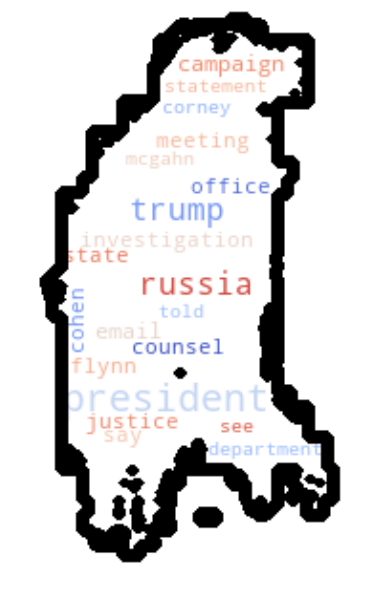

In [16]:
# show plot
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Sentiment Analysis

In [17]:
def get_swn_word_sentiment(token, tag):
    """
        Function to retrieve sentiment polarity average between negative, positive sentiment based on SentiWordNet
        Objective sentiment is not included in sentiment score
        Sentiment score = positive - negative score

        Input: str
        Output: float
    """
    senti_score = 0.0
    lemmatizer = WordNetLemmatizer()
    # convert to WordNet part of speech tag
    wn_tag = penn_to_wn(tag = tag)
    
    # other tags arent supported by sentiword
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
        pass
    else:
        lemma = lemmatizer.lemmatize(token, wn_tag)
        
        if not lemma:
            pass
        else:
            try:
                # convert word to synset 
                synsets = swn.senti_synsets(lemma, pos = wn_tag)
                if not synsets:
                    pass
                else:
                    synset = synsets[0]
                    # return positive - negative sentiment score
                    senti_score = synset.pos_score() -  synset.neg_score()
                    return senti_score
            except:
                pass


In [636]:
def get_swn_sentiment(sentence):
    """
    Function to retrieve sentiment polarity average between negative, positive sentiment based on SentiWordNet
    Objective sentiment is not included in total score
    Sentiment score = positive - negative score
    Input: str
    Output: float
    """
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(word_tokenize(sentence)):
        wn_tag = penn_to_wn(tag = pos)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
            continue
        lemma = lemmatizer.lemmatize(word, wn_tag)
        synsets = swn.senti_synsets(lemma, pos=wn_tag)
        if not synsets:
            continue
        synset = synsets[0]
        # not using avg anymore 
        # avg_sentiment = np.nanmean([synset.pos_score(), synset.neg_score()])
        sentiment = synset.pos_score()  -  synset.neg_score()
        return(sentiment)

In [18]:
# read mueller_text (has sentences from PDF)
with open('./data/mueller_text.txt','r') as f:
    mueller_text = f.readlines()

In [19]:
# parse pdf to text
start = 9
end =  439
pdffile = "mueller-report-searchable.pdf"

text_result = parsePDF(filename = pdffile, page_start= start, page_end=end)


('processed page', '9')
('processed page', '10')
('processed page', '11')
('processed page', '12')
('processed page', '13')
('processed page', '14')
('processed page', '15')
('processed page', '16')
('processed page', '17')
('processed page', '18')
('processed page', '19')
('processed page', '20')
('processed page', '21')
('processed page', '22')
('processed page', '23')
('processed page', '24')
('processed page', '25')
('processed page', '26')
('processed page', '27')
('processed page', '28')
('processed page', '29')
('processed page', '30')
('processed page', '31')
('processed page', '32')
('processed page', '33')
('processed page', '34')
('processed page', '35')
('processed page', '36')
('processed page', '37')
('processed page', '38')
('processed page', '39')
('processed page', '40')
('processed page', '41')
('processed page', '42')
('processed page', '43')
('processed page', '44')
('processed page', '45')
('processed page', '46')
('processed page', '47')
('processed page', '48')
(

('processed page', '330')
('processed page', '331')
('processed page', '332')
('processed page', '333')
('processed page', '334')
('processed page', '335')
('processed page', '336')
('processed page', '337')
('processed page', '338')
('processed page', '339')
('processed page', '340')
('processed page', '341')
('processed page', '342')
('processed page', '343')
('processed page', '344')
('processed page', '345')
('processed page', '346')
('processed page', '347')
('processed page', '348')
('processed page', '349')
('processed page', '350')
('processed page', '351')
('processed page', '352')
('processed page', '353')
('processed page', '354')
('processed page', '355')
('processed page', '356')
('processed page', '357')
('processed page', '358')
('processed page', '359')
('processed page', '360')
('processed page', '361')
('processed page', '362')
('processed page', '363')
('processed page', '364')
('processed page', '365')
('processed page', '366')
('processed page', '367')
('processed 

In [20]:
# create a list for each sentence
sentences = sent_tokenize(text_result)

In [31]:
from functions import cleanup_text, penn_to_wn, get_tokens, get_swn_word_sentiment

In [25]:
'''
    1st Attempt - without removing stop words
    loop through sentences and get sentiment score for each word
    ignore words where sentiment = 0
    put results in 2 lists - one for impt words and another for sentiment scores
'''
imp_words = []
scores = []
tags = []

for sentence in sentences:
    for word, tag in pos_tag(word_tokenize(cleanup_text(sentence))):
        sentiments = get_swn_word_sentiment(word, tag)
        if sentiments:
            word_sentiment = np.sum(sentiments)
            if word_sentiment >0:
                print("word: {}, sentiment: {}".format(word, word_sentiment))
                imp_words.append(word)
                scores.append(word_sentiment)
                tags.append(tag)

word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: activities, sentiment: 0.125
word: considerations, sentiment: 0.25
word: be, sentiment: 0.125
word: credible, sentiment: 0.625
word: enabled, sentiment: 0.375
word: was, sentiment: 0.125
word: e, sentiment: 0.375
word: was, sentiment: 0.125
word: has, sentiment: 0.25
word: been, sentiment: 0.125
word: invoked, sentiment: 0.125
word: is, sentiment: 0.125
word: liability, sentiment: 0.25
word: is, sentiment: 0.125
word: focus, sentiment: 0.125
word: liability, sentiment: 0.25
word: was, sentiment: 0.125
word: defined, sentiment: 0.375
word: factual, sentiment: 0.5
word: activities, sentiment: 0.125
word: coordination, sentiment: 0.5
word: have, sentiment: 0.25
word: understood, sentiment: 0.375
word: coordination, sentiment: 0.5
word: were, sentiment: 0.125
word: coordination, sentiment: 0.5
word: sense, sentiment: 0.375
word: activities, sentiment: 0.125
word: factual, sentiment: 0.5
word: section, sentiment: 0.125
word: sec

word: justice, sentiment: 0.25
word: similar, sentiment: 0.125
word: have, sentiment: 0.25
word: believes, sentiment: 0.125
word: is, sentiment: 0.125
word: necessary, sentiment: 0.625
word: appropriate, sentiment: 0.125
word: is, sentiment: 0.125
word: applicable, sentiment: 0.5
word: sections, sentiment: 0.125
word: clarified, sentiment: 0.25
word: explained, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: categorically, sentiment: 0.25
word: release, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: sets, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: was, sentiment: 0.125
word: administration, sentiment: 0.375
word: agent, sentiment: 0.5
word: sets, sentiment: 0.125
word: security, sentiment: 0.375
word: thorough, sentiment: 0.75
word: was, sentiment: 0.125
word: pertinent, sentiment: 0.375
word: activities, sentiment: 0.125
word: confirmation, sentiment: 0.375
word: has, sentiment: 0.25
wor

word: slamming, sentiment: 0.25
word: justice, sentiment: 0.25
word: ambassador, sentiment: 0.375
word: jr, sentiment: 0.125
word: promoted, sentiment: 0.125
word: activities, sentiment: 0.125
word: approximately, sentiment: 0.25
word: approximately, sentiment: 0.25
word: were, sentiment: 0.125
word: is, sentiment: 0.125
word: old, sentiment: 0.375
word: mental, sentiment: 0.125
word: be, sentiment: 0.125
word: promote, sentiment: 0.125
word: larger, sentiment: 0.125
word: were, sentiment: 0.125
word: had, sentiment: 0.25
word: justice, sentiment: 0.25
word: had, sentiment: 0.25
word: approximately, sentiment: 0.25
word: believed, sentiment: 0.125
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: contact, sentiment: 0.375
word: promoted, sentiment: 0.125
word: promote, sentiment: 0.125
word: large, sentiment: 0.125
word: were, sentiment: 0.125
word: promoted, sentiment: 0.125
word: was, sentiment: 0.125
word: even, sentiment: 0.125
word: have, sentiment: 0.25
word: reach, 

word: be, sentiment: 0.125
word: qualities, sentiment: 0.375
word: be, sentiment: 0.125
word: bright, sentiment: 0.125
word: well, sentiment: 0.375
word: approximately, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: explained, sentiment: 0.25
word: liberal, sentiment: 0.625
word: has, sentiment: 0.25
word: has, sentiment: 0.25
word: available, sentiment: 0.375
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: want, sentiment: 0.25
word: want, sentiment: 0.25
word: be, sentiment: 0.125
word: be, sentiment: 0.125
word: encourage, sentiment: 0.125
word: even, sentiment: 0.125
word: important, sentiment: 0.875
word: contact, sentiment: 0.375
word: release, sentiment: 0.125
word: possible, sentiment: 0.5
word: coordination, sentiment: 0.5
word: release, sentiment: 0.125
word: was, sentiment: 0.125
word: are, sentiment: 0.125
word: support, sentiment: 0.125
word: have, sentiment: 0.25
word: financial, sentiment: 0.25
word: was, sentiment: 0.125
wor

word: release, sentiment: 0.125
word: was, sentiment: 0.125
word: were, sentiment: 0.125
word: be, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: release, sentiment: 0.125
word: was, sentiment: 0.125
word: adversely, sentiment: 0.25
word: affect, sentiment: 0.125
word: set, sentiment: 0.125
word: had, sentiment: 0.25
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: believed, sentiment: 0.125
word: was, sentiment: 0.125
word: focused, sentiment: 0.125
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: release, sentiment: 0.125
word: had, sentiment: 0.25
word: gotten, sentiment: 0.125
word: contact, sentiment: 0.375
word: justice, sentiment: 0.25
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: convinced, sentiment: 0.125
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word:

word: section, sentiment: 0.125
word: jr, sentiment: 0.125
word: has, sentiment: 0.25
word: been, sentiment: 0.125
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: musical, sentiment: 0.25
word: jr, sentiment: 0.125
word: e, sentiment: 0.375
word: justice, sentiment: 0.25
word: accept, sentiment: 0.125
word: flat, sentiment: 0.125
word: be, sentiment: 0.125
word: called, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: being, sentiment: 0.125
word: be, sentiment: 0.125
word: is, sentiment: 0.125
word: have, sentiment: 0.25
word: jr, sentiment: 0.125
word: e, sentiment: 0.375
word: jr, sentiment: 0.125
word: e, sentiment: 0.375
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: e, sentiment: 0.375
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: was, sentiment: 0.125
word: are, sentiment: 0.125
word: bailing, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentim

word: e, sentiment: 0.375
word: was, sentiment: 0.125
word: wanted, sentiment: 0.25
word: are, sentiment: 0.125
word: had, sentiment: 0.25
word: is, sentiment: 0.125
word: believe, sentiment: 0.125
word: obviously, sentiment: 0.5
word: want, sentiment: 0.25
word: big, sentiment: 0.125
word: was, sentiment: 0.125
word: believe, sentiment: 0.125
word: want, sentiment: 0.25
word: prominent, sentiment: 0.125
word: was, sentiment: 0.125
word: wanted, sentiment: 0.25
word: invite, sentiment: 0.125
word: like, sentiment: 0.125
word: invite, sentiment: 0.125
word: is, sentiment: 0.125
word: wants, sentiment: 0.25
word: are, sentiment: 0.125
word: be, sentiment: 0.125
word: is, sentiment: 0.125
word: perfect, sentiment: 0.5
word: be, sentiment: 0.125
word: well, sentiment: 0.375
word: want, sentiment: 0.25
word: dates, sentiment: 0.125
word: are, sentiment: 0.125
word: dates, sentiment: 0.125
word: date, sentiment: 0.125
word: am, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentime

word: acknowledged, sentiment: 0.125
word: had, sentiment: 0.25
word: having, sentiment: 0.25
word: executive, sentiment: 0.25
word: responsible, sentiment: 0.625
word: had, sentiment: 0.25
word: believed, sentiment: 0.125
word: was, sentiment: 0.125
word: being, sentiment: 0.125
word: odd, sentiment: 0.125
word: had, sentiment: 0.25
word: best, sentiment: 0.75
word: arrange, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: e, sentiment: 0.375
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: have, sentiment: 0.25
word: had, sentiment: 0.25
word: release, sentiment: 0.125
word: be, sentiment: 0.125
word: e, sentiment: 0.375
word: was, sentiment: 0.125
word: contacts, sentiment: 0.375
word: senior, sentiment: 0.375
word: has, sentiment: 0.25
word: is, sentiment: 0.125
word: advantage, sentiment: 0.625
word: being, sentiment: 0.125
word: is, s

word: was, sentiment: 0.125
word: consideration, sentiment: 0.25
word: speaking, sentiment: 0.125
word: commencement, sentiment: 0.125
word: love, sentiment: 0.5
word: have, sentiment: 0.25
word: want, sentiment: 0.25
word: be, sentiment: 0.125
word: am, sentiment: 0.125
word: be, sentiment: 0.125
word: able, sentiment: 0.125
word: wanted, sentiment: 0.25
word: is, sentiment: 0.125
word: new, sentiment: 0.375
word: justice, sentiment: 0.25
word: material, sentiment: 0.125
word: e, sentiment: 0.375
word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: known, sentiment: 0.5
word: have, sentiment: 0.25
word: be, sentiment: 0.125
word: happy, sentiment: 0.875
word: wanted, sentiment: 0.25
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: have, sentiment: 0.25
word: is, sentiment: 0.125
word: being, sentiment: 0.125
word: main, sentiment: 0.375
word: better, sentiment: 0.375
word: have, sentiment: 0.25
word: focus, sentiment: 0.125
word: ideas, sentiment: 0.125
word: corr

word: justice, sentiment: 0.25
word: believed, sentiment: 0.125
word: senior, sentiment: 0.375
word: was, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: love, sentiment: 0.5
word: arranged, sentiment: 0.125
word: jr, sentiment: 0.125
word: invited, sentiment: 0.125
word: senior, sentiment: 0.375
word: jr, sentiment: 0.125
word: have, sentiment: 0.25
word: submitted, sentiment: 0.125
word: has, sentiment: 0.25
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: activities, sentiment: 0.125
word: were, sentiment: 0.125
word: jr, sentiment: 0.125
word: support, sentiment: 0.125
word: claims, sentiment: 0.125
word: financial, sentiment: 0.25
word: sanctions, sentiment: 0.25
word: retaliatory, sentiment: 0.125
word: jr, sentiment: 0.125
word: issue, sentiment: 0.125
word: be, sentiment: 0.125
word: was, sentiment: 0.125
word: jr, sentiment: 0.125
word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: enterprise, sentimen

word: activities, sentiment: 0.125
word: focus, sentiment: 0.125
word: was, sentiment: 0.125
word: jr, sentiment: 0.125
word: had, sentiment: 0.25
word: reliability, sentiment: 0.625
word: accuracy, sentiment: 0.5
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: has, sentiment: 0.25
word: is, sentiment: 0.125
word: jr, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: jr, sentiment: 0.125
word: informed, sentiment: 0.375
word: consideration, sentiment: 0.25
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: call, sentiment: 0.25
word: called, sentiment: 0.25
word: had, sentiment: 0.25
word: well, sentiment: 0.375
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: waste, sentiment: 0.125
word: was, sentiment: 0.125
word: were, sentiment: 0

word: district, sentiment: 0.25
word: conduct, sentiment: 0.25
word: issue, sentiment: 0.125
word: well, sentiment: 0.375
word: was, sentiment: 0.125
word: district, sentiment: 0.25
word: be, sentiment: 0.125
word: section, sentiment: 0.125
word: district, sentiment: 0.25
word: has, sentiment: 0.25
word: has, sentiment: 0.25
word: deemed, sentiment: 0.25
word: be, sentiment: 0.125
word: reliable, sentiment: 0.375
word: jr, sentiment: 0.125
word: credit, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: new, sentiment: 0.375
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: peace, sentiment: 0.125
word: has, sentiment: 0.25
word: acknowledged, sentiment: 0.125
word: was, sentiment: 0.125
word: success, sentiment: 0.125
word: support, sentiment: 0.125
word: succeed, sentiment: 0.125
word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: were, sentiment: 0.125
word: reception, sentiment: 0.5
word: peace, sentiment: 0.125
word: peace, sentimen

word: e, sentiment: 0.375
word: having, sentiment: 0.25
word: acknowledged, sentiment: 0.125
word: had, sentiment: 0.25
word: cut, sentiment: 0.125
word: have, sentiment: 0.25
word: convince, sentiment: 0.125
word: favor, sentiment: 0.125
word: peace, sentiment: 0.125
word: have, sentiment: 0.25
word: support, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: acknowledged, sentiment: 0.125
word: peace, sentiment: 0.125
word: win, sentiment: 0.125
word: be, sentiment: 0.125
word: ideal, sentiment: 0.75
word: peace, sentiment: 0.125
word: facilitate, sentiment: 0.375
word: were, sentiment: 0.125
word: necessary, sentiment: 0.625
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: sets, sentiment: 0.125
word: financial, sentiment: 0.25
word: be, sentiment: 0.125
word: able, sentiment: 0.125
word: was, sentiment: 0.125
word: wanted, sentiment: 0.25
word: activities, sentiment: 0.125
word: approximately, sentiment: 0.25
word: contacts, sentiment: 0.375

word: administration, sentiment: 0.375
word: want, sentiment: 0.25
word: is, sentiment: 0.125
word: understand, sentiment: 0.375
word: are, sentiment: 0.125
word: had, sentiment: 0.25
word: contacts, sentiment: 0.375
word: had, sentiment: 0.25
word: permission, sentiment: 0.125
word: be, sentiment: 0.125
word: able, sentiment: 0.125
word: positive, sentiment: 0.625
word: new, sentiment: 0.375
word: was, sentiment: 0.125
word: invited, sentiment: 0.125
word: was, sentiment: 0.125
word: chance, sentiment: 0.5
word: love, sentiment: 0.5
word: invite, sentiment: 0.125
word: administration, sentiment: 0.375
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: focused, sentiment: 0.125
word: jr, sentiment: 0.125
word: am, sentiment: 0.125
word: e, sentiment: 0.375
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: was, sentiment: 0.125
wor

word: executive, sentiment: 0.25
word: had, sentiment: 0.25
word: section, sentiment: 0.125
word: have, sentiment: 0.25
word: similar, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: am, sentiment: 0.125
word: judiciary, sentiment: 0.25
word: am, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: security, sentiment: 0.375
word: new, sentiment: 0.375
word: thoughts, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: important, sentiment: 0.875
word: have, sentiment: 0.25
word: believed, sentiment: 0.125
word: be, sentiment: 0.125
word: be, sentiment: 0.125
word: security, sentiment: 0.375
word: acknowledged, sentiment: 0.125
word: had, sentiment: 0.25
word: get, sentiment: 0.125
word: forward, sentiment: 0.25
word: has, sentiment: 0.25
word: being, sentiment: 0.125
word: had, sentiment: 0.25
word: already, sentiment: 0.125
word: was, sentiment: 0.125
word: contact, sentiment: 0.375
word: forward, senti

word: gladstone, sentiment: 0.125
word: new, sentiment: 0.375
word: have, sentiment: 0.25
word: validity, sentiment: 0.375
word: security, sentiment: 0.375
word: security, sentiment: 0.375
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: sanctions, sentiment: 0.25
word: administration, sentiment: 0.375
word: sanctions, sentiment: 0.25
word: senior, sentiment: 0.375
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: contact, sentiment: 0.375
word: were, sentiment: 0.125
word: sanctions, sentiment: 0.25
word: sanctions, sentiment: 0.25
word: were, sentiment: 0.125
word: retaliatory, sentiment: 0.125
word: administration, sentiment: 0.375
word: were, sentiment: 0.125
word: sanctions, sentiment: 0.25
word: get, sentiment: 0.125
word: kindly, sentiment: 0.5
word: call, sentiment: 0.25
word: convenience, sentiment: 0.375
word: called, sentiment: 0.25
word: am, sentiment: 0.125
word: sanctions, sentiment: 0.25
word: were, sentiment: 0.125


word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: justice, sentiment: 0.25
word: focus, sentiment: 0.125
word: liability, sentiment: 0.25
word: was, sentiment: 0.125
word: defined, sentiment: 0.375
word: considered, sentiment: 0.125
word: contacts, sentiment: 0.375
word: liability, sentiment: 0.25
word: have, sentiment: 0.25
word: contacts, sentiment: 0.375
word: section, sentiment: 0.125
word: are, sentiment: 0.125
word: contacts, sentiment: 0.375
word: section, sentiment: 0.125
word: section, sentiment: 0.125
word: lawful, sentiment: 0.125
word: lawful, sentiment: 0.125
word: section, sentiment: 0.125
word: intentionally, sentiment: 0.375
word: section, sentiment: 0.125
word: contacts, sentiment: 0.375
word: section, sentiment: 0.125
word: coordination, sentiment: 0.5
word: agent, sentiment: 0.5
word: liability, sentiment: 0.25
word: is, sentiment: 0.125
word: agent, sentiment: 0.5
word: liability, sentiment: 0.25
word: agent, sentiment: 0.5
word:

word: reasonable, sentiment: 0.5
word: doubt, sentiment: 0.125
word: well, sentiment: 0.375
word: be, sentiment: 0.125
word: factual, sentiment: 0.5
word: is, sentiment: 0.125
word: surely, sentiment: 0.25
word: was, sentiment: 0.125
word: well, sentiment: 0.375
word: be, sentiment: 0.125
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: jrs, sentiment: 0.125
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: understood, sentiment: 0.25
word: being, sentiment: 0.125
word: uncertain, sentiment: 0.125
word: reliability, sentiment: 0.625
word: be, sentiment: 0.125
word: be, sentiment: 0.125
word: jrs, sentiment: 0.125
word: love, sentiment: 0.5
word: emphasis, sentiment: 0.75
word: mental, sentiment: 0.125
word: required, sentiment: 0.125
word: jr, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: knowingly, sentiment: 0.125
word: willfully, sentiment: 0.25
word: conduct, sentimen

word: ambassador, sentiment: 0.375
word: regarding, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: contact, sentiment: 0.375
word: nature, sentiment: 0.5
word: plausible, sentiment: 0.5
word: have, sentiment: 0.25
word: had, sentiment: 0.25
word: explained, sentiment: 0.25
word: understood, sentiment: 0.375
word: narrowly, sentiment: 0.125
word: calling, sentiment: 0.25
word: routine, sentiment: 0.125
word: contacts, sentiment: 0.375
word: was, sentiment: 0.125
word: is, sentiment: 0.125
word: plausible, sentiment: 0.5
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: willfully, sentiment: 0.25
word: considered, sentiment: 0.125
word: be, sentiment: 0.125
word: was, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: considerations, sentiment: 0.25
word: justice, sentiment: 0.25
word: justice, sentiment: 0.25
word: submitted, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: justice, s

word: justice, sentiment: 0.25
word: called, sentiment: 0.25
word: call, sentiment: 0.25
word: had, sentiment: 0.25
word: be, sentiment: 0.125
word: regarded, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: have, sentiment: 0.25
word: affect, sentiment: 0.125
word: oval, sentiment: 0.125
word: trusted, sentiment: 0.5
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: forward, sentiment: 0.25
word: understood, sentiment: 0.375
word: wanted, sentiment: 0.25
word: be, sentiment: 0.125
word: new, sentiment: 0.375
word: clear, sentiment: 0.5
word: was, sentiment: 0.125
word: want, sentiment: 0.25
word: senior, sentiment: 0.375
word: was, sentiment: 0.125
word: prevent, sentiment: 0.25
word: were, sentiment: 0.125
word: senior, sentiment: 0.375
word: jr, sentiment: 0.125
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: be, sentiment: 0.125
word: jr, sentiment: 0.125
word: acknowledged, sentiment: 0.125
word: was, sentiment: 0.125
word: jr

word: corruptly, sentiment: 0.25
word: section, sentiment: 0.125
word: corruptly, sentiment: 0.25
word: conduct, sentiment: 0.25
word: justice, sentiment: 0.25
word: prevent, sentiment: 0.25
word: prevent, sentiment: 0.25
word: possible, sentiment: 0.5
word: is, sentiment: 0.125
word: investigators, sentiment: 1.0
word: contemplation, sentiment: 0.125
word: likely, sentiment: 0.5
word: conduct, sentiment: 0.25
word: be, sentiment: 0.125
word: coercive, sentiment: 0.25
word: is, sentiment: 0.125
word: e, sentiment: 0.375
word: e, sentiment: 0.375
word: is, sentiment: 0.125
word: were, sentiment: 0.125
word: true, sentiment: 0.125
word: believe, sentiment: 0.125
word: even, sentiment: 0.125
word: was, sentiment: 0.125
word: actually, sentiment: 0.375
word: true, sentiment: 0.125
word: be, sentiment: 0.125
word: be, sentiment: 0.125
word: is, sentiment: 0.125
word: prevent, sentiment: 0.25
word: section, sentiment: 0.125
word: have, sentiment: 0.25
word: are, sentiment: 0.125
word: likely

word: e, sentiment: 0.375
word: new, sentiment: 0.375
word: section, sentiment: 0.125
word: section, sentiment: 0.125
word: justice, sentiment: 0.25
word: material, sentiment: 0.125
word: e, sentiment: 0.375
word: instructed, sentiment: 0.5
word: releases, sentiment: 0.125
word: was, sentiment: 0.125
word: releases, sentiment: 0.125
word: be, sentiment: 0.125
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: strategy, sentiment: 0.125
word: possible, sentiment: 0.5
word: release, sentiment: 0.125
word: was, sentiment: 0.125
word: release, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: whole, sentiment: 0.125
word: was, sentiment: 0.125
word: assertion, sentiment: 0.375
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: pause, sentiment: 0.125
word: had, sentiment: 0.25
word: able, sentiment: 0.125
word: are, sentiment: 0.125
word: be, sentiment: 0.125
word: rewarded, sentiment:

word: administration, sentiment: 0.375
word: issue, sentiment: 0.125
word: was, sentiment: 0.125
word: possible, sentiment: 0.5
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: justice, sentiment: 0.25
word: material, sentiment: 0.125
word: e, sentiment: 0.375
word: sanctions, sentiment: 0.25
word: administration, sentiment: 0.375
word: was, sentiment: 0.125
word: smart, sentiment: 0.5
word: called, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: had, sentiment: 0.25
word: sanctions, sentiment: 0.25
word: had, sentiment: 0.25
word: administration, sentiment: 0.375
word: sanctions, sentiment: 0.25
word: sanctions, sentiment: 0.25
word: issue, sentiment: 0.125
word: administration, sentiment: 0.375
word: had, sentiment: 0.25
word: sanctions, sentiment: 0.25
word: sanctions, sentiment: 0.25
word: have, sentiment: 0.25
word: intelligence, sentiment: 0.5
word: were, sentiment: 0.125
word: surprised, sentiment: 0.125
word: sanctions, sentiment: 0.25


word: e, sentiment: 0.375
word: wanted, sentiment: 0.25
word: had, sentiment: 0.25
word: wanted, sentiment: 0.25
word: having, sentiment: 0.25
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: has, sentiment: 0.25
word: serious, sentiment: 0.125
word: issues, sentiment: 0.125
word: acknowledge, sentiment: 0.125
word: loyalty, sentiment: 0.25
word: loyalty, sentiment: 0.25
word: loyalty, sentiment: 0.25
word: get, sentiment: 0.125
word: honesty, sentiment: 0.125
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: want, sentiment: 0.25
word: honest, sentiment: 0.375
word: loyalty, sentiment: 0.25
word: get, sentiment: 0.125
word: had, sentime

word: vice, sentiment: 0.25
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: sanctions, sentiment: 0.25
word: ambassador, sentiment: 0.375
word: equivocated, sentiment: 0.125
word: security, sentiment: 0.375
word: contact, sentiment: 0.375
word: today, sentiment: 0.125
word: were, sentiment: 0.125
word: constant, sentiment: 0.375
word: senior, sentiment: 0.375
word: furor, sentiment: 0.25
word: courtesy, sentiment: 0.5
word: new, sentiment: 0.375
word: justice, sentiment: 0.25
word: vice, sentiment: 0.25
word: acceptable, sentiment: 0.625
word: sanctions, sentiment: 0.25
word: certainly, sentiment: 0.25
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: have, sentiment: 0.25
word: have, sentiment: 0.25
word: had, sentiment: 0.25
word: having, sentiment: 0.25
word: have, sentiment: 0.25
word: have, sentiment: 0.25
word: have, sentiment: 0.25
word: had, sentiment: 0.25
word: have, sentiment: 0.25
word: wanted, sentiment: 0.25
word: security, sentiment: 0.375
word:

word: justice, sentiment: 0.25
word: ma, sentiment: 0.875
word: material, sentiment: 0.125
word: e, sentiment: 0.375
word: perceive, sentiment: 0.375
word: was, sentiment: 0.125
word: called, sentiment: 0.25
word: understood, sentiment: 0.375
word: be, sentiment: 0.125
word: confirmation, sentiment: 0.375
word: presidency, sentiment: 0.25
word: favorable, sentiment: 0.75
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: happy, sentiment: 0.875
word: rules, sentiment: 0.25
word: want, sentiment: 0.25
word: called, sentiment: 0.25
word: believed, sentiment: 0.125
word: was, sentiment: 0.125
word: called, sentiment: 0.25
word: called, sentiment: 0.25
word: check, sentiment: 0.5
word: was, sentiment: 0.125
word: awesome, sentiment: 0.75
word: wanted, sentiment: 0.25
word: was, sentiment: 0.125
word: justice, sentiment: 0.25
word: release, sentiment: 0.125
word: have, sentiment: 0.25
word: senior, sentiment: 0.375
word: having, sentiment: 0.25
word: today, sentiment: 0.125
word: 

word: called, sentiment: 0.25
word: called, sentiment: 0.25
word: was, sentiment: 0.125
word: ability, sentiment: 0.5
word: get, sentiment: 0.125
word: were, sentiment: 0.125
word: true, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: documenting, sentiment: 0.125
word: perceive, sentiment: 0.375
word: be, sentiment: 0.125
word: had, sentiment: 0.25
word: get, sentiment: 0.125
word: had, sentiment: 0.25
word: get, sentiment: 0.125
word: was, sentiment: 0.125
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: intelligence, sentiment: 0.5
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: believed, sentiment: 0.125
word: be, sentiment: 0.125
word: pressured, sentiment: 0.25
word: intelligence, sentiment: 0.5
word: ability, sentiment: 0.5
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: was, sentiment: 0.125
word: had, sentiment

word: am, sentiment: 0.125
word: being, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: justice, sentiment: 0.25
word: new, sentiment: 0.375
word: be, sentiment: 0.125
word: consider, sentiment: 0.125
word: was, sentiment: 0.125
word: clear, sentiment: 0.5
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: new, sentiment: 0.375
word: senior, sentiment: 0.375
word: wanted, sentiment: 0.25
word: had, sentiment: 0.25
word: ideas, sentiment: 0.125
word: be, sentiment: 0.125
word: greatly, sentiment: 0.125
word: am, sentiment: 0.125
word: have, sentiment: 0.25
word: is, sentiment: 0.125
word: be, sentiment: 0.125
word: believe, sentiment: 0.125
word: support, sentiment: 0.125
word: justice, sentiment: 0.25
word: material, sentiment: 0.125
word: e, sentiment: 0.375
word: was, sentiment: 0.125
word: were, sentiment: 0.125
word: was, sentiment: 

word: had, sentiment: 0.25
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: want, sentiment: 0.25
word: even, sentiment: 0.125
word: belongings, sentiment: 0.5
word: loved, sentiment: 0.5
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: justice, sentiment: 0.25
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: accepted, sentiment: 0.125
word: recommendation, sentiment: 0.25
word: performance, sentiment: 0.125
word: concerns, sentiment: 0.25
word: agents, sentiment: 0.5
word: supported, sentiment: 0.125
word: different, sentiment: 0.625
word: good, sentiment: 0.75
word: was, sentiment: 0.125
word: agents, sentiment: 0.5
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: concern, sentiment: 0.25
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
w

word: submit, sentiment: 0.125
word: oval, sentiment: 0.125
word: being, sentiment: 0.125
word: extremely, sentiment: 0.625
word: had, sentiment: 0.25
word: agents, sentiment: 0.5
word: instructed, sentiment: 0.5
word: sorted, sentiment: 0.125
word: wanted, sentiment: 0.25
word: wanted, sentiment: 0.25
word: was, sentiment: 0.125
word: wanted, sentiment: 0.25
word: hand, sentiment: 0.5
word: was, sentiment: 0.125
word: concerned, sentiment: 0.125
word: be, sentiment: 0.125
word: justice, sentiment: 0.25
word: was, sentiment: 0.125
word: good, sentiment: 0.75
word: have, sentiment: 0.25
word: was, sentiment: 0.125
word: section, sentiment: 0.125
word: had, sentiment: 0.25
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: wanted, sentiment: 0.25
word: had, sentiment: 0.25
word: get, sentiment: 0.125
word: was, sentiment: 0.125
word: accepting, sentiment: 0.125
word: senior, sentiment: 0.375
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: accepted, sentiment: 0.

word: wanted, sentiment: 0.25
word: want, sentiment: 0.25
word: had, sentiment: 0.25
word: called, sentiment: 0.25
word: have, sentiment: 0.25
word: was, sentiment: 0.125
word: don, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: directive, sentiment: 0.125
word: was, sentiment: 0.125
word: called, sentiment: 0.25
word: nature, sentiment: 0.5
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: calling, sentiment: 0.25
word: christie, sentiment: 0.125
word: christie, sentiment: 0.125
word: was, sentiment: 0.125
word: have, sentiment: 0.25
word: is, sentiment: 0.125
word: justice, sentiment: 0.25
word: qualify, sentiment: 0.625
word: believed, sentiment: 0.125
word: want, sentiment: 0.25
word: don, sentiment: 0.125
word: christie, sentiment: 0.125
word: christie, sentiment: 0.125
word: precise, sentiment: 0.75
word: date, sentiment: 0.125
word: believed, sentiment: 0.125
word: was, sentiment: 0

word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: new, sentiment: 0.375
word: be, sentiment: 0.125
word: able, sentiment: 0.125
word: new, sentiment: 0.375
word: was, sentiment: 0.125
word: about, sentiment: 0.25
word: ambassador, sentiment: 0.375
word: intelligence, sentiment: 0.5
word: contacts, sentiment: 0.375
word: are, sentiment: 0.125
word: section, sentiment: 0.125
word: justice, sentiment: 0.25
word: ma, sentiment: 0.875
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: new, sentiment: 0.375
word: intelligence, sentiment: 0.5
word: amazon, sentiment: 0.125
word: approximately, sentiment: 0.25
word: are, sentiment: 0.125
word: had, sentiment: 0.25
word: get, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: tolerable, sentiment: 0.125
word: had, sentiment: 0.25
word: get, sentiment: 0.125
word: new, sentiment: 0.375
word: justice, sentiment: 0.25
word: believed, sentiment: 0.125
word: was, sentiment: 0.125
word: called, sentiment

word: convinced, sentiment: 0.125
word: be, sentiment: 0.125
word: get, sentiment: 0.125
word: be, sentiment: 0.125
word: were, sentiment: 0.125
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: new, sentiment: 0.375
word: new, sentiment: 0.375
word: jr, sentiment: 0.125
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: new, sentiment: 0.375
word: new, sentiment: 0.375
word: new, sentiment: 0.375
word: new, sentiment: 0.375
word: justice, sentiment: 0.25
word: feel, sentiment: 0.125
word: e, sentiment: 0.375
word: questioned, sentiment: 0.75
word: democratic, sentiment: 0.375
word: had, sentiment: 0.25
word: arranged, sentiment: 0.125
word: was, sentiment: 0.125
word: called, sentiment: 0.25
word: had, sentiment: 0.25
word: called, sentiment: 0.25
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: jr, sentiment: 0.125
word: was, sentiment: 0.125
word: purposely, sentiment: 0.375
word: had, sentim

word: good, sentiment: 0.75
word: justice, sentiment: 0.25
word: was, sentiment: 0.125
word: have, sentiment: 0.25
word: wasted, sentiment: 0.125
word: better, sentiment: 0.75
word: was, sentiment: 0.125
word: right, sentiment: 0.25
word: justice, sentiment: 0.25
word: were, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: had, sentiment: 0.25
word: justice, sentiment: 0.25
word: justice, sentiment: 0.25
word: was, sentiment: 0.125
word: am, sentiment: 0.125
word: justice, sentiment: 0.25
word: be, sentiment: 0.125
word: considerations, sentiment: 0.25
word: justice, sentiment: 0.25
word: be, sentiment: 0.125
word: considerations, sentiment: 0.25
word: is, sentiment: 0.125
word: wants, sentiment: 0.25
word: corruption, sentiment: 0.25
word: much, sentiment: 0.125
word: is, sentiment: 0.125
word: have, sentiment: 0.25
word: considerations, sentiment: 0.25
word: are, sentiment: 0.125
word: justice, sentiment: 0.25
word: have, sentiment: 0.25
word: qualify, s

word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: conduct, sentiment: 0.25
word: section, sentiment: 0.125
word: had, sentiment: 0.25
word: have, sentiment: 0.25
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: were, sentiment: 0.125
word: were, sentiment: 0.125
word: being, sentiment: 0.125
word: considered, sentiment: 0.125
word: justice, sentiment: 0.25
word: be, sentiment: 0.125
word: had, sentiment: 0.25
word: have, sentiment: 0.25
word: were, sentiment: 0.125
word: new, sentiment: 0.375
word: typical, sentiment: 0.125
word: new, sentiment: 0.375
word: oval, sentiment: 0.125
word: focused, sentiment: 0.125
word: had, sentiment: 0.25
word: assertion, sentiment: 0.375
word: oval, sentiment: 0.125
word: had, sentiment: 0.25
word: have, sentiment: 0.25
word: even, sentiment: 0.125
word: oval, sentiment: 0.125
word: oval, sentiment: 0.125
word: justice, sentiment: 0.25
word: differed, sentiment: 0.25
word: was, sentiment: 0.125
word: broke, sentiment: 0.125
wor

word: e, sentiment: 0.375
word: rely, sentiment: 0.375
word: big, sentiment: 0.125
word: is, sentiment: 0.125
word: has, sentiment: 0.25
word: been, sentiment: 0.125
word: yet, sentiment: 0.25
word: district, sentiment: 0.25
word: is, sentiment: 0.125
word: right, sentiment: 0.25
word: is, sentiment: 0.125
word: totally, sentiment: 0.5
word: are, sentiment: 0.125
word: are, sentiment: 0.125
word: highly, sentiment: 0.625
word: prominent, sentiment: 0.125
word: respected, sentiment: 0.875
word: was, sentiment: 0.125
word: old, sentiment: 0.375
word: have, sentiment: 0.25
word: was, sentiment: 0.125
word: legendary, sentiment: 0.875
word: solitary, sentiment: 0.125
word: is, sentiment: 0.125
word: were, sentiment: 0.125
word: certainly, sentiment: 0.25
word: been, sentiment: 0.125
word: clear, sentiment: 0.5
word: been, sentiment: 0.125
word: unfairly, sentiment: 0.25
word: was, sentiment: 0.125
word: submitted, sentiment: 0.125
word: had, sentiment: 0.25
word: be, sentiment: 0.125
word:

word: submitted, sentiment: 0.125
word: consider, sentiment: 0.125
word: had, sentiment: 0.25
word: had, sentiment: 0.25
word: asserted, sentiment: 0.125
word: believed, sentiment: 0.125
word: get, sentiment: 0.125
word: called, sentiment: 0.25
word: had, sentiment: 0.25
word: awareness, sentiment: 0.5
word: section, sentiment: 0.125
word: vice, sentiment: 0.25
word: had, sentiment: 0.25
word: section, sentiment: 0.125
word: investigators, sentiment: 1.0
word: district, sentiment: 0.25
word: investigators, sentiment: 1.0
word: corrected, sentiment: 0.25
word: be, sentiment: 0.125
word: consistent, sentiment: 0.25
word: has, sentiment: 0.25
word: accepted, sentiment: 0.125
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: approximately, sentiment: 0.25
word: have, sentiment: 0.25
word: had, sentiment: 0.25
word: wanted, sentiment: 0.25
word: be, sentiment: 0.125
word: was, sentiment: 0.125
word: jr, sentiment: 0.125
word: highly, sentiment: 0.625
word: lucrative, sentiment:

word: e, sentiment: 0.375
word: be, sentiment: 0.125
word: had, sentiment: 0.25
word: explaining, sentiment: 0.25
word: whole, sentiment: 0.125
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: submitting, sentiment: 0.125
word: was, sentiment: 0.125
word: had, sentiment: 0.25
word: wanted, sentiment: 0.25
word: be, sentiment: 0.125
word: had, sentiment: 0.25
word: was, sentiment: 0.125
word: truth, sentiment: 0.625
word: getting, sentiment: 0.125
word: speaking, sentiment: 0.125
word: was, sentiment: 0.125
word: be, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: adhered, sentiment: 0.375
word: whole, sentiment: 0.125
word: wanted, sentiment: 0.25
word: believed, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: submitted, sentiment: 0.125
word: was, sentiment: 0.125
word: have, sentiment: 0.25
word: contacts, sentiment: 0.375
word: seconds, sentiment: 0.5
word: contacts, sentiment: 0.375
word: contacts, sentiment:

word: attaching, sentiment: 0.125
word: justice, sentiment: 0.25
word: is, sentiment: 0.125
word: possible, sentiment: 0.5
word: being, sentiment: 0.125
word: aware, sentiment: 0.5
word: regarding, sentiment: 0.125
word: regarding, sentiment: 0.125
word: deems, sentiment: 0.25
word: had, sentiment: 0.25
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: primary, sentiment: 0.375
word: was, sentiment: 0.125
word: focused, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: good, sentiment: 0.75
word: chance, sentiment: 0.5
word: have, sentiment: 0.25
word: won, sentiment: 0.125
word: opportunities, sentiment: 0.5
word: was, sentiment: 0.125
word: being, sentiment: 0.125
word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: get, sentiment: 0.125
word: regarding, sentiment: 0.125
word: even, sentiment: 0.1

word: was, sentiment: 0.125
word: was, sentiment: 0.125
word: supports, sentiment: 0.125
word: were, sentiment: 0.125
word: factual, sentiment: 0.5
word: issues, sentiment: 0.125
word: supports, sentiment: 0.125
word: conduct, sentiment: 0.25
word: justice, sentiment: 0.25
word: conduct, sentiment: 0.25
word: conduct, sentiment: 0.25
word: implicate, sentiment: 0.125
word: constitutional, sentiment: 0.75
word: issues, sentiment: 0.125
word: constitutional, sentiment: 0.75
word: issues, sentiment: 0.125
word: section, sentiment: 0.125
word: factual, sentiment: 0.5
word: conduct, sentiment: 0.25
word: have, sentiment: 0.25
word: were, sentiment: 0.125
word: lawful, sentiment: 0.125
word: powerful, sentiment: 0.25
word: justice, sentiment: 0.25
word: material, sentiment: 0.125
word: conduct, sentiment: 0.25
word: strong, sentiment: 0.5
word: had, sentiment: 0.25
word: is, sentiment: 0.125
word: is, sentiment: 0.125
word: even, sentiment: 0.125
word: is, sentiment: 0.125
word: even, sentim

word: feel, sentiment: 0.125
word: commencement, sentiment: 0.125
word: conduct, sentiment: 0.25
word: integrity, sentiment: 0.625
word: section, sentiment: 0.125
word: breadth, sentiment: 0.125
word: is, sentiment: 0.125
word: reinforced, sentiment: 0.125
word: corruptly, sentiment: 0.25
word: endeavors, sentiment: 0.125
word: administration, sentiment: 0.375
word: justice, sentiment: 0.25
word: section, sentiment: 0.125
word: has, sentiment: 0.25
word: been, sentiment: 0.125
word: be, sentiment: 0.125
word: is, sentiment: 0.125
word: essentially, sentiment: 0.5
word: conduct, sentiment: 0.25
word: administration, sentiment: 0.375
word: justice, sentiment: 0.25
word: have, sentiment: 0.25
word: has, sentiment: 0.25
word: explained, sentiment: 0.25
word: are, sentiment: 0.125
word: similar, sentiment: 0.125
word: conduct, sentiment: 0.25
word: justice, sentiment: 0.25
word: justice, sentiment: 0.25
word: section, sentiment: 0.125
word: section, sentiment: 0.125
word: have, sentiment: 0

word: has, sentiment: 0.25
word: has, sentiment: 0.25
word: granting, sentiment: 0.375
word: free, sentiment: 0.375
word: enterprise, sentiment: 0.125
word: be, sentiment: 0.125
word: faithfully, sentiment: 0.25
word: executed, sentiment: 0.125
word: has, sentiment: 0.25
word: broad, sentiment: 0.125
word: enact, sentiment: 0.125
word: grand, sentiment: 0.25
word: constitutional, sentiment: 0.75
word: constitutional, sentiment: 0.75
word: is, sentiment: 0.125
word: reconciled, sentiment: 0.125
word: corruptly, sentiment: 0.25
word: endeavors, sentiment: 0.125
word: proper, sentiment: 0.75
word: administration, sentiment: 0.375
word: is, sentiment: 0.125
word: being, sentiment: 0.125
word: had, sentiment: 0.25
word: proper, sentiment: 0.75
word: is, sentiment: 0.125
word: being, sentiment: 0.125
word: had, sentiment: 0.25
word: justice, sentiment: 0.25
word: feel, sentiment: 0.125
word: has, sentiment: 0.25
word: constitutional, sentiment: 0.75
word: justice, sentiment: 0.25
word: justi

word: absolute, sentiment: 0.5
word: privilege, sentiment: 0.5
word: confidential, sentiment: 0.125
word: constitutional, sentiment: 0.75
word: workable, sentiment: 0.375
word: gravely, sentiment: 0.125
word: have, sentiment: 0.25
word: has, sentiment: 0.25
word: executive, sentiment: 0.25
word: are, sentiment: 0.125
word: necessary, sentiment: 0.625
word: proper, sentiment: 0.75
word: free, sentiment: 0.375
word: enterprise, sentiment: 0.125
word: is, sentiment: 0.125
word: important, sentiment: 0.875
word: faithfully, sentiment: 0.25
word: execute, sentiment: 0.125
word: has, sentiment: 0.25
word: are, sentiment: 0.125
word: is, sentiment: 0.125
word: be, sentiment: 0.125
word: free, sentiment: 0.375
word: enterprise, sentiment: 0.125
word: principal, sentiment: 0.375
word: furthers, sentiment: 0.375
word: ability, sentiment: 0.5
word: are, sentiment: 0.125
word: faithfully, sentiment: 0.25
word: executed, sentiment: 0.125
word: are, sentiment: 0.125
word: be, sentiment: 0.125
word: 

word: confidential, sentiment: 0.125
word: be, sentiment: 0.125
word: invoke, sentiment: 0.125
word: privilege, sentiment: 0.125
word: support, sentiment: 0.125
word: claim, sentiment: 0.125
word: probing, sentiment: 0.25
word: is, sentiment: 0.125
word: constitutional, sentiment: 0.75
word: being, sentiment: 0.125
word: be, sentiment: 0.125
word: serious, sentiment: 0.125
word: liability, sentiment: 0.25
word: serious, sentiment: 0.125
word: believe, sentiment: 0.125
word: asserted, sentiment: 0.5
word: have, sentiment: 0.25
word: been, sentiment: 0.125
word: grand, sentiment: 0.25
word: is, sentiment: 0.125
word: rarer, sentiment: 0.25
word: even, sentiment: 0.125
word: conduct, sentiment: 0.25
word: be, sentiment: 0.125
word: hypothetical, sentiment: 0.125
word: concerns, sentiment: 0.25
word: possible, sentiment: 0.5
word: contrary, sentiment: 0.625
word: issues, sentiment: 0.125
word: had, sentiment: 0.25
word: valid, sentiment: 0.125
word: conduct, sentiment: 0.25
word: issue, se

word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: democratic, sentiment: 0.375
word: democratic, sentiment: 0.375
word: security, sentiment: 0.375
word: main, sentiment: 0.375
word: intelligence, sentiment: 0.5
word: select, sentiment: 0.625
word: intelligence, sentiment: 0.5
word: practice, sentiment: 0.125
word: new, sentiment: 0.375
word: security, sentiment: 0.375
word: intelligence, sentiment: 0.5
word: select, sentiment: 0.625
word: intelligence, sentiment: 0.5
word: justice, sentiment: 0.25
word: ma, sentiment: 0.875
word: e, sentiment: 0.375
word: justice, sentiment: 0.25
word: justice, sentiment: 0.25
word: e, sentiment: 0.375
word: submitted, sentiment: 0.125
word: explain, sentiment: 0.25
word: attach, sentiment: 0.125
word: was, sentiment: 0.125
word: justice, sentiment: 0.25
word: conduct, sentiment: 0.25
word: is, sentiment: 0.125
word: grand, sentiment: 0.25
word: justice, sentiment: 0.25
word: is, sentiment: 0.125
word: vital, sentiment: 0.5
word: had, sent

word: were, sentiment: 0.125
word: yes, sentiment: 0.25
word: understood, sentiment: 0.375
word: was, sentiment: 0.125
word: were, sentiment: 0.125
word: yes, sentiment: 0.25
word: understood, sentiment: 0.375
word: was, sentiment: 0.125
word: regarding, sentiment: 0.125
word: yes, sentiment: 0.25
word: understood, sentiment: 0.375
word: was, sentiment: 0.125
word: justice, sentiment: 0.25
word: feel, sentiment: 0.125
word: e, sentiment: 0.375
word: jr, sentiment: 0.125
word: was, sentiment: 0.125
word: considering, sentiment: 0.125
word: attached, sentiment: 0.125
word: is, sentiment: 0.125
word: jr, sentiment: 0.125
word: jr, sentiment: 0.125
word: had, sentiment: 0.25
word: jr, sentiment: 0.125
word: yes, sentiment: 0.25
word: was, sentiment: 0.125
word: being, sentiment: 0.125
word: yes, sentiment: 0.25
word: jr, sentiment: 0.125
word: set, sentiment: 0.125
word: were, sentiment: 0.125
word: were, sentiment: 0.125
word: were, sentiment: 0.125
word: had, sentiment: 0.25
word: justic

word: is, sentiment: 0.125
word: attached, sentiment: 0.125
word: was, sentiment: 0.125
word: were, sentiment: 0.125
word: were, sentiment: 0.125
word: attached, sentiment: 0.125
word: best, sentiment: 0.75
word: was, sentiment: 0.125
word: contact, sentiment: 0.375
word: had, sentiment: 0.25
word: regarding, sentiment: 0.125
word: have, sentiment: 0.25
word: regarding, sentiment: 0.125
word: yes, sentiment: 0.25
word: e, sentiment: 0.375
word: justice, sentiment: 0.25
word: feel, sentiment: 0.125
word: e, sentiment: 0.375
word: were, sentiment: 0.125
word: had, sentiment: 0.25
word: been, sentiment: 0.125
word: yes, sentiment: 0.25
word: was, sentiment: 0.125
word: have, sentiment: 0.25
word: regarding, sentiment: 0.125
word: be, sentiment: 0.125
word: had, sentiment: 0.25
word: yes, sentiment: 0.25
word: have, sentiment: 0.25
word: have, sentiment: 0.25
word: attached, sentiment: 0.125
word: was, sentiment: 0.125
word: consistent, sentiment: 0.25
word: significant, sentiment: 0.375
w

In [26]:
# create dataframe with words, tags and scores
sent_data = pd.DataFrame({'imp_words':imp_words, 'scores':scores, 'partofspeech':tags})
sent_data.sort_values(by = 'scores', ascending=False).head(10)

,imp_words,partofspeech,scores
11656,investigators,NNS,1.0
11134,investigators,NNS,1.0
8216,investigators,NNS,1.0
12127,investigators,NNS,1.0
10305,investigators,NNS,1.0
1115,investigators,NNS,1.0
7111,investigators,NNS,1.0
8768,investigators,NNS,1.0
10004,investigators,NNS,1.0
2660,investigators,NNS,1.0


In [27]:
# get stats on words - which words have highest score & count
word_stats = sent_data.groupby('imp_words').scores.agg({'score_mean':'mean', 'score_counts':'count'})

is deprecated and will be removed in a future version [ipykernel_launcher.py:2]


In [28]:
word_stats.sort_values(by=['score_mean','score_counts'], ascending=False).head()

,score_counts,score_mean
imp_words,,
investigators,44,1.000
excellent,1,1.000
praise,1,1.000
important,35,0.875
ma,34,0.875


In [32]:
## Perform same analysis: use cleaned up text this time - with no stopwords
sentence = sentences[3]
print(sentence)
for word, tag in pos_tag(get_tokens(sentence)):
    score = get_swn_word_sentiment(word, tag)
    print(word, tag, score)

* * * Below we describe the evidentiary considerations underpinning statements about the results of our investigation and the Special Counsel's charging decisions, and we then provide an overview of the two volumes of our report.
(u'describe', 'NN', None)
(u'evidentiary', 'JJ', 0.0)
(u'considerations', 'NNS', 0.25)
(u'underpinning', 'VBG', 0.0)
(u'statements', 'NNS', 0.0)
(u'results', 'NNS', 0.0)
(u'investigation', 'NN', 0.0)
(u'special', 'JJ', 0.0)
(u'counsel', 'NN', 0.0)
(u'charging', 'VBG', 0.0)
(u'decisions', 'NNS', 0.0)
(u'provide', 'VBP', 0.0)
(u'overview', 'CD', None)
(u'two', 'CD', None)
(u'volumes', 'NNS', 0.0)
(u'report', 'NN', 0.0)


In [33]:
'''
    2nd Attempt - removing stop words
    loop through sentences and get sentiment score for each word
    ignore words where sentiment = 0
    put results in 2 lists - one for impt words and another for sentiment scores
'''
imp_words = []
scores = []
tags = []
ids = []

for ix, sentence in enumerate(sentences):
    for word, tag in pos_tag(get_tokens(sentence)):
        lemmatizer = WordNetLemmatizer()
        word_sentiment = get_swn_word_sentiment(word, tag)
        if word_sentiment > 0:
            lemma = lemmatizer.lemmatize(word, penn_to_wn(tag))
            print("word: {}, lemma: {}, tag: {}, sentiment: {}".format(word, lemma, tag, word_sentiment))
            imp_words.append(lemma)
            scores.append(word_sentiment)
            tags.append(tag)
            ids.append(ix)

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: activities, lemma: activity, tag: NNS, sentiment: 0.125
word: considerations, lemma: consideration, tag: NNS, sentiment: 0.25
word: credible, lemma: credible, tag: JJ, sentiment: 0.625
word: enabled, lemma: enable, tag: VBD, sentiment: 0.375
word: reach, lemma: reach, tag: NN, sentiment: 0.25
word: invoked, lemma: invoke, tag: VBN, sentiment: 0.125
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: focus, lemma: focus, tag: NN, sentiment: 0.125
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: defined, lemma: define, tag: VBN, sentiment: 0.375
word: factual, lemma: factual, tag: JJ, sentiment: 0.5
word: activities, lemma: activity, tag: NNS, sentiment: 0.125
word: coordination, lemma: coordination, tag: NN, sentiment: 0.5
word: understood, lemma: understood, tag: JJ, sentiment: 0.25
word: coordination, lemma: coordination, tag: NN, sentiment: 0.5
word: coordination, lemma: coordination, tag: NN

word: investigators, lemma: investigator, tag: NNS, sentiment: 1.0
word: nature, lemma: nature, tag: NN, sentiment: 0.5
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: peace, lemma: peace, tag: NN, sentiment: 0.125
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: ambassador, lemma: ambassador, tag: NN, sentiment: 0.375
word: assistance, lemma: assistance, tag: NN, sentiment: 0.5
word: activities, lemma: activity, tag: NNS, sentiment: 0.125
word: invoked, lemma: invoke, tag: VBD, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: privilege, lemma: privilege, tag: NN, sentiment: 0.5
word: screened, lemma: screen, tag: VBD, sentiment: 0.375
word: investigators, lemma: investigator, tag: NNS, sentiment: 1.0
word: even, lemma: even, tag: RB, sentiment: 0.125
word: practical, lemma: practical, tag: JJ, sentiment: 0.125
word: abi

word: new, lemma: new, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: otherwise, lemma: otherwise, tag: RB, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: happy, lemma: happy, tag: JJ, sentiment: 0.875
word: dear, lemma: dear, tag: JJ, sentiment: 0.5
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: ranging, lemma: range, tag: VBG, sentiment: 0.125
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: feel, lemma: feel, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: friends, lemma: friend, tag: NNS, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: responsible, lemma: responsible, tag: JJ, sentiment: 0.625
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: focusing, lemma: focus, tag: VBG, sentiment: 0.125
word: larger, lemma: large, tag: JJR, s

word: trusted, lemma: trust, tag: VBN, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: release, lemma: release, tag: NN, sentiment: 0.125
word: releases, lemma: release, tag: NNS, sentiment: 0.125
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: primary, lemma: primary, tag: JJ, sentiment: 0.375
word: well, lemma: well, tag: RB, sentiment: 0.375
word: credentials, lemma: credential, tag: NNS, sentiment: 0.125
word: opportunity, lemma: opportunity, tag: NN, sentiment: 0.5
word: approximately, lemma: approximately, tag: RB, sentiment: 0.25
word: enabled, lemma: enable, tag: VBD, sentiment: 0.375
word: enables, lemma: enable, tag: VBZ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: make, lemma: make, tag: NN, sentiment: 0.5
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: credentials, lemma: credential, tag: NNS, sentiment: 0.125
word: successfully, lemma: successfully, tag: RB, sentiment: 0.1

word: issue, lemma: issue, tag: NN, sentiment: 0.125
word: reward, lemma: reward, tag: NN, sentiment: 0.625
word: interested, lemma: interested, tag: JJ, sentiment: 0.625
word: interested, lemma: interested, tag: JJ, sentiment: 0.625
word: want, lemma: want, tag: VB, sentiment: 0.25
word: certainly, lemma: certainly, tag: RB, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: serious, lemma: serious, tag: JJ, sentiment: 0.125
word: serious, lemma: serious, tag: JJ, sentiment: 0.125
word: seriously, lemma: seriously, tag: RB, sentiment: 0.25
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: democratic, lemma: democratic, tag: JJ, sentiment: 0.375
word: responsible, lemma: responsible, tag: JJ, sentiment: 0.625
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: hope, lemma: hope, tag: NN, sentiment: 0.125
word: able, lemma: able, tag: JJ, sentiment: 0.125
word: rewarded, lemma: reward, tag: VBD, sentiment: 0.375
wo

word: even, lemma: even, tag: RB, sentiment: 0.125
word: security, lemma: security, tag: NN, sentiment: 0.375
word: coordination, lemma: coordination, tag: NN, sentiment: 0.5
word: independent, lemma: independent, tag: JJ, sentiment: 0.125
word: financial, lemma: financial, tag: JJ, sentiment: 0.25
word: initiative, lemma: initiative, tag: NN, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: got, lemma: get, tag: VBD, sentiment: 0.125
word: detailed, lemma: detailed, tag: JJ, sentiment: 0.5
word: technical, lemma: technical, tag: JJ, sentiment: 0.125
word: possible, lemma: possible, tag: JJ, sentiment: 0.5
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: web, lemma: web, tag: NN, sentiment: 0.25
word: wanted, lemma: want, tag: VBD, sentiment: 0.25
word: authenticity, lemma: authenticity, tag: NN, sentiment: 0.125
word: originally, lemma: originally, tag: RB, sentiment: 0.125
word: attached, l

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: incorrectly, lemma: incorrectly, tag: RB, sentiment: 0.25
word: trusted, lemma: trust, tag: VBD, sentiment: 0.375
word: facilitate, lemma: facilitate, tag: VB, sentiment: 0.375
word: willingness, lemma: willingness, tag: NN, sentiment: 0.125
word: emphatic, lemma: emphatic, tag: JJ, sentiment: 0.25
word: possible, lemma: possible, tag: JJ, sentiment: 0.5
word: possible, lemma: possible, tag: JJ, sentiment: 0.5
word: well, lemma: well, tag: RB, sentiment: 0.375
word: important, lemma: important, tag: JJ, sentiment: 0.875
word: significant, lemma: significant, tag: JJ, sentiment: 0.375
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: contact, lemma: contact, tag: NN, sentiment: 0.375
word: wanted, lemma: want, tag: VBD, sentiment: 0.25
word: claims, lemma: claim, tag: NNS, sentiment: 0.125
word: level, lemma: level, tag: JJ, sentiment: 0.125
word: completely, lemma: completely, tag: RB, sentiment: 0.5
word: d

word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: section, lemma: section, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: release, lemma: release, tag: NN, sentiment: 0.125
word: shared, lemma: share, tag: VBN, sentiment: 0.125
word: arrange, lemma: arrange, tag: VBP, sentiment: 0.125
word: ben, lemma: ben, tag: NN, sentiment: 0.125
word: race, lemma: race, tag: NN, sentiment: 0.125
word: actively, lemma: actively, tag: RB, sentiment: 0.5
word: contact, lemma: contact, tag: NN, sentiment: 0.375
word: practice, lemma: practice, tag: NN, sentiment: 0.125
word: unique, lemma: unique, tag: JJ, sentiment: 0.375
word: comprising, lemma: comprise, tag: VBG, sentiment: 0.125
word: high-level, lemma: high-level, tag: JJ, sentiment: 0.625
word: dedicated, lemma: dedicate, tag: VBN, sentiment: 0.125
word: practice, lemma: practice, tag: NN, sentiment: 0.125
word: nature, lemma: nature, tag: NN, sentiment: 0.5
word: pursuant, lemma: pursuant,

word: admitted, lemma: admit, tag: VBD, sentiment: 0.125
word: specifically, lemma: specifically, tag: RB, sentiment: 0.375
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: release, lemma: release, tag: NN, sentiment: 0.125
word: sections, lemma: section, tag: NNS, sentiment: 0.125
word: sharing, lemma: share, tag: VBG, sentiment: 0.125
word: release, lemma: release, tag: NN, sentiment: 0.125
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: section, lemma: section, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: shared, lemma: share, tag: VBN, sentiment: 0.125
word: contact, lemma: contact, tag: NN, sentiment: 0.375
word: able, lemma: able, tag: JJ, sentiment: 0.125
word: meet, lemma: meet, tag: JJ, sentiment: 0.625
word: native, lemma: native, tag: JJ, sentiment: 0.125
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentimen

word: probe, lemma: probe, tag: VBP, sentiment: 0.25
word: probe, lemma: probe, tag: VBP, sentiment: 0.25
word: instructing, lemma: instruct, tag: VBG, sentiment: 0.5
word: contact, lemma: contact, tag: NN, sentiment: 0.375
word: activities, lemma: activity, tag: NNS, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: section, lemma: section, tag: NN, sentiment: 0.125
word: chief, lemma: chief, tag: JJ, sentiment: 0.375
word: expertise, lemma: expertise, tag: NN, sentiment: 0.375
word: born, lemma: bear, tag: VBN, sentiment: 0.125
word: security, lemma: security, tag: NN, sentiment: 0.375
word: ambassador, lemma: ambassador, tag: NN, sentiment: 0.375
word: confirmation, lemma: confirmation, tag: NN, sentiment: 0.375
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: realism, lemma: realism, tag: NN, sentiment: 0.125
word: security, lemm

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: approximately, lemma: approximately, tag: RB, sentiment: 0.25
word: administrative, lemma: administrative, tag: JJ, sentiment: 0.25
word: district, lemma: district, tag: NN, sentiment: 0.25
word: financial, lemma: financial, tag: JJ, sentiment: 0.25
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: restrictions, lemma: restriction, tag: NNS, sentiment: 0.25
word: named, lemma: name, tag: VBD, sentiment: 0.25
word: exposed, lemma: expose, tag: VBN, sentiment: 0.125
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: exposed, lemma: expose, tag: VBD, sentiment: 0.125
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: district, lemma: district, tag: NN, sentiment: 0.25
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: district, lemma: district, tag: NN, sentiment: 0.25
word: judiciary, lemma: judiciary, tag: NN, sentiment: 0.25
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma:

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: ambassadors, lemma: ambassador, tag: NNS, sentiment: 0.375
word: hands, lemma: hand, tag: NNS, sentiment: 0.5
word: improving, lemma: improve, tag: VBG, sentiment: 0.375
word: ambassadors, lemma: ambassador, tag: NNS, sentiment: 0.375
word: believed, lemma: believe, tag: VBN, sentiment: 0.125
word: pleasantries, lemma: pleasantry, tag: NNS, sentiment: 0.75
word: reception, lemma: reception, tag: NN, sentiment: 0.5
word: prepared, lemma: prepared, tag: JJ, sentiment: 0.625
word: ambassadors, lemma: ambassador, tag: NNS, sentiment: 0.375
word: improving, lemma: improve, tag: VBG, sentiment: 0.375
word: belief, lemma: belief, tag: NN, sentiment: 0.125
word: better, lemma: well, tag: RBR, sentiment: 0.375
word: security, lemma: security, tag: NN, sentiment: 0.375
word: section, lemma: section, tag: NN, sentiment: 0.125
word: explaining, lemma: explain, tag: VBG, sentiment: 0.25
word: reception, lemma: reception, tag: NN, sentime

word: supporting, lemma: support, tag: VBG, sentiment: 0.125
word: understood, lemma: understood, tag: JJ, sentiment: 0.25
word: presidency, lemma: presidency, tag: NN, sentiment: 0.25
word: trusted, lemma: trusted, tag: JJ, sentiment: 0.5
word: popular, lemma: popular, tag: JJ, sentiment: 0.125
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: facilitated, lemma: facilitate, tag: VBD, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: believe, lemma: believe, tag: VBP, sentiment: 0.125
word: born, lemma: bear, tag: VBN, sentiment: 0.125
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: strong, lemma: strong, tag: JJ, sentiment: 0.5
word: well, lemma: well, tag: RB, sentiment: 0.375
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: mot, lemma: mot, tag: NN, sentiment: 0.375
word: mot, lemma: mot, tag: NN, sentiment: 0.375
word: pursuant, lemma: pursuant, tag: JJ, sentiment: 0.125
word: agents, lemma: agent

word: security, lemma: security, tag: NN, sentiment: 0.375
word: important, lemma: important, tag: JJ, sentiment: 0.875
word: want, lemma: want, tag: VBP, sentiment: 0.25
word: issue, lemma: issue, tag: NN, sentiment: 0.125
word: regarding, lemma: regard, tag: VBG, sentiment: 0.125
word: peace, lemma: peace, tag: NN, sentiment: 0.125
word: detailed, lemma: detailed, tag: JJ, sentiment: 0.5
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: acknowledged, lemma: acknowledge, tag: VBN, sentiment: 0.125
word: apparent, lemma: apparent, tag: JJ, sentiment: 0.625
word: basically, lemma: basically, tag: RB, sentiment: 0.5
word: district, lemma: district, tag: NN, sentiment: 0.25
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: regarding, lemma: regard, tag: VBG, sentiment: 0.125
word: peace, lemma: peace, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: contacts, lemma

word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: check, lemma: check, tag: VB, sentiment: 0.5
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: positive, lemma: positive, tag: JJ, sentiment: 0.625
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: approximately, lemma: approximately, tag: RB, sentiment: 0.25
word: booked, lemma: book, tag: VBD, sentiment: 0.125
word: surprise, lemma: surprise, tag: NN, sentiment: 0.125
word: arranged, lemma: arrange, tag: VBD, sentiment: 0.125
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: enthusiastic, lemma: enthusiastic, tag: JJ, sentiment: 0.625
word: idea, lemma: idea, tag: NN, sentiment: 0.125
word: influence, lemma: influence, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: well, lemma: well, tag: RB, sentiment: 0.375
word: trusted, lemma: trust, tag: VBD, sentiment: 0.375
word: n

word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: financial, lemma: financial, tag: JJ, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: even, lemma: even, tag: RB, sentiment: 0.125
word: gifts, lemma: gift, tag: NNS, sentiment: 0.25
word: differ, lemma: differ, tag: VBP, sentiment: 0.25
word: nature, lemma: nature, tag: NN, sentiment: 0.5
word: improved, lemma: improved, tag: JJ, sentiment: 0.375
word: lending, lemma: lend, tag: VBG, sentiment: 0.25
word: possible, lemma: possible, tag: JJ, sentiment: 0.5
word: major, lemma: major, tag: JJ, sentiment: 0.625
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: sections, lemma: section, tag: NNS, sentiment: 0.125
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: financial, lemma: financial, tag: JJ, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
wo

word: new, lemma: new, tag: JJ, sentiment: 0.375
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: get, lemma: get, tag: VBP, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: ability, lemma: ability, tag: NN, sentiment: 0.5
word: good, lemma: good, tag: JJ, sentiment: 0.75
word: believed, lemma: believe, tag: VBD, sentiment: 0.125
word: believed, lemma: believe, tag: VBD, sentiment: 0.125
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: tom, lemma: tom, tag: NN, sentiment: 0.125
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: good, lemma: good, tag: JJ, sentiment: 0.75
word: today, lemma: today, tag: NN, sentiment: 0.125
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: security, lemma: security, tag: NN, sentiment: 0.375
wor

word: coordination, lemma: coordination, tag: NN, sentiment: 0.5
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: invoked, lemma: invoke, tag: VBN, sentiment: 0.125
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: contrary, lemma: contrary, tag: JJ, sentiment: 0.625
word: even, lemma: even, tag: RB, sentiment: 0.125
word: defined, lemma: define, tag: VBD, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: focus, lemma: focus, tag: NN, sentiment: 0.125
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: defined, lemma: define, tag: VBN, sentiment: 0.375
word: considered, lemma: consider, tag: VBD, sentiment: 0.125
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: section, lemma: section, tag: NN, sentiment: 0.125
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: section

word: tendency, lemma: tendency, tag: NN, sentiment: 0.375
word: ingratiate, lemma: ingratiate, tag: VB, sentiment: 0.125
word: gift, lemma: gift, tag: NN, sentiment: 0.25
word: tangible, lemma: tangible, tag: JJ, sentiment: 0.5
word: voluntary, lemma: voluntary, tag: JJ, sentiment: 0.125
word: similar, lemma: similar, tag: JJ, sentiment: 0.125
word: accurate, lemma: accurate, tag: JJ, sentiment: 0.5
word: uncertain, lemma: uncertain, tag: JJ, sentiment: 0.125
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: even, lemma: even, tag: RB, sentiment: 0.125
word: challenges, lemma: challenge, tag: NNS, sentiment: 0.125
word: likely, lemma: likely, tag: JJ, sentiment: 0.5
word: reasonable, lemma: reasonable, tag: JJ, sentiment: 0.5
word: doubt, lemma: doubt, tag: NN, sentiment: 0.125
word: knowingly, lemma: knowingly, tag: RB, sentiment: 0.125
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: elevated, lemma: ele

word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: call, lemma: call, tag: VBP, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: calls, lemma: call, tag: VBZ, sentiment: 0.25
word: regarding, lemma: regard, tag: VBG, sentiment: 0.125
word: submitted, lemma: submit, tag: VBN, sentiment: 0.125
word: security, lemma: security, tag: NN, sentiment: 0.375
word: specifically, lemma: specifically, tag: RB, sentiment: 0.375
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: vote, lemma: vote, tag: NN, sentiment: 0.125
word: regarding, lemma: regard, tag: VBG, sentiment: 0.125
word: vote, lemma: vote, tag: NN, sentiment: 0.125
word: security, lemma: security, tag: NN, sentiment: 0.375
word: otherwise, lemma: otherwise, tag: RB, sentiment: 0.375
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: totality, l

word: constitutional, lemma: constitutional, tag: JJ, sentiment: 0.75
word: constitutional, lemma: constitutional, tag: JJ, sentiment: 0.75
word: considerations, lemma: consideration, tag: NNS, sentiment: 0.25
word: strong, lemma: strong, tag: JJ, sentiment: 0.5
word: amenability, lemma: amenability, tag: NN, sentiment: 0.125
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: preclude, lemma: preclude, tag: VB, sentiment: 0.25
word: otherwise, lemma: otherwise, tag: RB, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: feel, lemma: feel, tag: NN, sentiment: 0.125
word: integrity, lemma: integrity, tag: NN, sentiment: 0.625
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: thorough, lemma: thorough, tag: JJ, sentiment: 0.75
word: factual, lemma: factual, tag: JJ, sentiment: 0.5
word: available, lemma: available, tag: JJ, sentiment: 0.375
word: considered, lemma: consider, tag: VBD,

word: warm, lemma: warm, tag: JJ, sentiment: 0.375
word: unfairly, lemma: unfairly, tag: RB, sentiment: 0.25
word: rule, lemma: rule, tag: NN, sentiment: 0.25
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: praise, lemma: praise, tag: NN, sentiment: 1.0
word: asserted, lemma: assert, tag: VBN, sentiment: 0.125
word: strong, lemma: strong, tag: JJ, sentiment: 0.5
word: believed, lemma: believe, tag: VBN, sentiment: 0.125
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: factual, lemma: factual, tag: JJ, sentiment: 0.5
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: typical, lemma: typical, tag: JJ, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word:

word: endeavor, lemma: endeavor, tag: NN, sentiment: 0.125
word: natural, lemma: natural, tag: JJ, sentiment: 0.25
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: citation, lemma: citation, tag: NN, sentiment: 0.125
word: foreseeable, lemma: foreseeable, tag: JJ, sentiment: 0.25
word: foreseeable, lemma: foreseeable, tag: JJ, sentiment: 0.25
word: brackets, lemma: bracket, tag: NNS, sentiment: 0.25
word: corruptly, lemma: corruptly, tag: RB, sentiment: 0.25
word: corruptly, lemma: corruptly, tag: RB, sentiment: 0.25
word: intent, lemma: intent, tag: JJ, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: knowingly, lemma: knowingly, tag: RB, sentiment: 0.125
word: dishonestly, lemma: dishonestly, tag: RB, sentiment: 0.25
word: corruptly, lemma: corruptly, tag: RB, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: knowingly, lemma: knowingly, tag: R

word: tend, lemma: tend, tag: VB, sentiment: 0.375
word: strongly, lemma: strongly, tag: RB, sentiment: 0.125
word: investigator, lemma: investigator, tag: NN, sentiment: 1.0
word: supports, lemma: support, tag: VBZ, sentiment: 0.125
word: consistent, lemma: consistent, tag: JJ, sentiment: 0.25
word: consciousness, lemma: consciousness, tag: NN, sentiment: 0.125
word: wrongdoing, lemma: wrongdoing, tag: NN, sentiment: 0.5
word: strong, lemma: strong, tag: JJ, sentiment: 0.5
word: factual, lemma: factual, tag: JJ, sentiment: 0.5
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: factual, lemma: factual, tag: JJ, sentiment: 0.5
word: section, lemma: section, tag: NN, sentiment: 0.125
word: issue, lemma: issue, tag: NN, sentiment: 0.125
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: confirmation, lemma: confirmation, tag: NN, sentiment: 0.375
word: prevent, lemma: prevent, tag: VBP, sentiment: 0.25
word: 

word: explained, lemma: explain, tag: VBN, sentiment: 0.25
word: scrutinized, lemma: scrutinize, tag: VBN, sentiment: 0.5
word: section, lemma: section, tag: NN, sentiment: 0.125
word: probe, lemma: probe, tag: VBP, sentiment: 0.25
word: security, lemma: security, tag: NN, sentiment: 0.375
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: security, lemma: security, tag: NN, sentiment: 0.375
word: security, lemma: security, tag: NN, sentiment: 0.375
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: security, lemma: security, tag: NN, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: hope, lemma: hope, tag: NN, sentiment: 0.125
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
wo

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: tet, lemma: tet, tag: NN, sentiment: 0.125
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: smart, lemma: smart, tag: JJ, sentiment: 0.5
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: issue, lemma: issue, tag: NN, sentiment: 0.125
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: calls, lemma: call, tag: VBZ, sentiment: 0.25
word: surprised, lemma: surprise, tag: VBD, sentiment: 0.125
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
wo

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: believed, lemma: believe, tag: VBN, sentiment: 0.125
word: doubts, lemma: doubt, tag: NNS, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: want, lemma: want, tag: VBP, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: possessed, lemma: possess, tag: VBD, sentiment: 0.5
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: invited, lemma: invite, tag: VBD, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: wanted, lemma: want, tag: VBD, sentiment: 0.25
word: surprised, lemma: surprise, tag: VBD, sentiment: 0.125
word: concerned, lemma: concerned, tag: JJ, sentiment: 0.125
word: burnham, lemma: burnham, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: burnham, lemma: burnham, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: available, lemma: available, tag: JJ

word: accurate, lemma: accurate, tag: JJ, sentiment: 0.5
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: highly, lemma: highly, tag: RB, sentiment: 0.625
word: confident, lemma: confident, tag: JJ, sentiment: 0.375
word: documenting, lemma: document, tag: VBG, sentiment: 0.125
word: outset, lemma: outset, tag: NN, sentiment: 0.125
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: hope, lemma: hope, tag: NN, sentiment: 0.125
word: wants, lemma: want, tag: VBZ, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: documenting, lemma: document, tag: VBG, sentiment: 0.125
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: forced, lemma: force, tag: VBD, sentiment: 0.25
word: contacts, lemma: contact, tag: NNS, sentiment: 

word: loyalty, lemma: loyalty, tag: NN, sentiment: 0.25
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: christie, lemma: christie, tag: NN, sentiment: 0.125
word: even, lemma: even, tag: RB, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: activities, lemma: activity, tag: NNS, sentiment: 0.125
word: believed, lemma: believe, tag: VBN, sentiment: 0.125
word: proper, lemma: proper, tag: JJ, sentiment: 0.75
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: highlights, lemma: highlight, tag: NNS, sentiment: 0.125
word: concern, lemma: concern, tag: NN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: documenting, lemma: document, tag: VBG, sentiment: 0.125
word: confirmation, lemma: confirmation, tag: NN, sentiment: 0.375
word: considering, lemma: consider, tag: VBG, sentiment: 0.125
wor

word: sustainable, lemma: sustainable, tag: JJ, sentiment: 0.625
word: idea, lemma: idea, tag: NN, sentiment: 0.125
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: oval, lemma: oval, tag: JJ, sentiment: 0.125
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: regularly, lemma: regularly, tag: RB, sentiment: 0.125
word: get, lemma: get, tag: VBP, sentiment: 0.125
word: different, lemma: different, tag: JJ, sentiment: 0.625
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: get, lemma: get, tag: VB, sentiment: 0.125
word: get, lemma: get, tag: VB, sentiment: 0.125
word: falling, lemma: fall, tag: VBG, sentiment: 0.125
word: wanting, lemma: want, tag: VBG, sentiment: 0.25
word: clear, lemma: clear, tag: JJ, sentiment: 0.5
word: get, lemma: get, tag: VB, sentiment: 0.125
word: burnham, lemma: burnham, tag: NN,

word: important, lemma: important, tag: JJ, sentiment: 0.875
word: ability, lemma: ability, tag: NN, sentiment: 0.5
word: explaining, lemma: explain, tag: VBG, sentiment: 0.25
word: question, lemma: question, tag: VBP, sentiment: 0.75
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: appropriate, lemma: appropriate, tag: VB, sentiment: 0.125
word: consider, lemma: consider, tag: VB, sentiment: 0.125
word: clear, lemma: clear, tag: JJ, sentiment: 0.5
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: wanted, lemma: want, tag: VBD, sentiment: 0.25
word: ideas, lemma: idea, tag: NNS, sentiment: 0.125
word: greatly, lemma: greatly, tag: RB, sentiment: 0.125
word: prepared, lemma: prepared, tag: JJ, sentiment: 0.625
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: clear, lemma: clear, tag: JJ, sentiment: 0.5
word: wanted, lemma: wanted, tag: JJ, sentiment: 0.6

word: agents, lemma: agent, tag: NNS, sentiment: 0.5
word: concern, lemma: concern, tag: NN, sentiment: 0.25
word: documenting, lemma: document, tag: VBG, sentiment: 0.125
word: consistent, lemma: consistent, tag: JJ, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: factually, lemma: factually, tag: RB, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: correct, lemma: correct, tag: VBP, sentiment: 0.25
word: get, lemma: get, tag: VB, sentiment: 0.125
word: right, lemma: right, tag: RB, sentiment: 0.25
word: really, lemma: really, tag: RB, sentiment: 0.625
word: recommendation, lemma: recommendation, tag: NN, sentiment: 0.25
word: recommendation, lemma: recommendation, tag: NN, sentiment: 0.25
word: recommendation, lemma: recommendation, tag: NN, sentiment: 0.25
word: good, lemma: good, tag: JJ, sentiment: 0.75
word: made-up, lemma: made-up, tag: JJ, sentiment: 0.125
word: absolutely, lemma: absolutely, tag: RB, sentiment: 0.5
wor

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: oval, lemma: oval, tag: JJ, sentiment: 0.125
word: extremely, lemma: extremely, tag: RB, sentiment: 0.625
word: agents, lemma: agent, tag: NNS, sentiment: 0.5
word: instructed, lemma: instruct, tag: VBN, sentiment: 0.5
word: sorted, lemma: sort, tag: VBD, sentiment: 0.125
word: pursuant, lemma: pursuant, tag: JJ, sentiment: 0.125
word: wanted, lemma: wanted, tag: JJ, sentiment: 0.625
word: wanted, lemma: want, tag: VBD, sentiment: 0.25
word: wanted, lemma: wanted, tag: JJ, sentiment: 0.625
word: hand, lemma: hand, tag: NN, sentiment: 0.5
word: concerned, lemma: concerned, tag: JJ, sentiment: 0.125
word: good, lemma: good, tag: JJ, sentiment: 0.75
word: section, lemma: section, tag: NN, sentiment: 0.125
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: wanted, lemma: wanted, tag: JJ, sentiment: 0.625
word: get, lemma: get, tag: VB, sentiment: 0.125
word: 

word: directive, lemma: directive, tag: NN, sentiment: 0.125
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: nature, lemma: nature, tag: NN, sentiment: 0.5
word: calling, lemma: call, tag: VBG, sentiment: 0.25
word: christie, lemma: christie, tag: NN, sentiment: 0.125
word: christie, lemma: christie, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: qualify, lemma: qualify, tag: VB, sentiment: 0.625
word: believed, lemma: believe, tag: VBN, sentiment: 0.125
word: want, lemma: want, tag: VBP, sentiment: 0.25
word: christie, lemma: christie, tag: NN, sentiment: 0.125
word: date, lemma: date, tag: NN, sentiment: 0.125
word: believed, lemma: believe, tag: VBD, sentiment: 0.125
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: christie, lemma: christie, tag: NN, sentiment: 0.125
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: christie, lemma: christie, tag: NN, sentiment: 0.125
word: christie, lemma: christie, tag: NN, sentime

word: new, lemma: new, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: extremely, lemma: extremely, tag: RB, sentiment: 0.625
word: loved, lemma: love, tag: VBD, sentiment: 0.5
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: joking, lemma: joke, tag: VBG, sentiment: 0.375
word: idea, lemma: idea, tag: NN, sentiment: 0.125
word: meet, lemma: meet, tag: JJ, sentiment: 0.625
word: called, lemma: call, tag: VBD, sentiment: 0.25
word: happy, lemma: happy, tag: JJ, sentiment: 0.875
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: ambassador, lemma: ambassador, tag: NN, sentiment: 0.375
word: contrary, lemma: contrary, tag: JJ, sentiment: 0.625
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: wanted, lemma: want, tag: VBN, sentiment: 0.25
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: able, lemma: abl

word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: feel, lemma: feel, tag: NN, sentiment: 0.125
word: questioned, lemma: question, tag: VBD, sentiment: 0.75
word: democratic, lemma: democratic, tag: JJ, sentiment: 0.375
word: arranged, lemma: arrange, tag: VBD, sentiment: 0.125
word: called, lemma: call, tag: VBD, sentiment: 0.25
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: purposely, lemma: purposely, tag: RB, sentiment: 0.375
word: get, lemma: get, tag: VB, sentiment: 0.125
word: call, lemma: call, tag: VBP, sentiment: 0.25
word: hope, lemma: hope, tag: NN, sentiment: 0.125
word: get, lemma: get, tag: VB, sentiment: 0.125
word: investigators, lemma: investigator, tag: NN

word: different, lemma: different, tag: JJ, sentiment: 0.625
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: district, lemma: district, tag: NN, sentiment: 0.25
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: section, lemma: section, tag: NN, sentiment: 0.125
word: evident, lemma: evident, tag: JJ, sentiment: 0.625
word: yet, lemma: yet, tag: RB, sentiment: 0.25
word: oval, lemma: oval, tag: JJ, sentiment: 0.125
word: principal, lemma: principal, tag: JJ, sentiment: 0.375
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: reasonable, lemma: reasonable, tag: JJ, sentiment: 0.5
word: be

word: necessary, lemma: necessary, tag: JJ, sentiment: 0.625
word: natural, lemma: natural, tag: JJ, sentiment: 0.25
word: tendency, lemma: tendency, tag: NN, sentiment: 0.375
word: investigators, lemma: investigator, tag: NNS, sentiment: 1.0
word: investigators, lemma: investigator, tag: NNS, sentiment: 1.0
word: influence, lemma: influence, tag: NN, sentiment: 0.25
word: investigators, lemma: investigator, tag: NNS, sentiment: 1.0
word: focused, lemma: focus, tag: VBD, sentiment: 0.125
word: strategy, lemma: strategy, tag: NN, sentiment: 0.125
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: approximately, lemma: approximately, tag: RB, sentiment: 0.25
word: typical, lemma: typical, tag: JJ, sentiment: 0.125
word: desired, lemma: desire, tag: VBD, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: issue, lemma: issue, tag: NN, sentiment: 0.125
word: focused, lemma: focus, tag: VBD, sentiment: 0.1

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: whole, lemma: whole, tag: JJ, sentiment: 0.125
word: fair, lemma: fair, tag: JJ, sentiment: 0.625
word: considering, lemma: consider, tag: VBG, sentiment: 0.125
word: really, lemma: really, tag: RB, sentiment: 0.625
word: considering, lemma: consider, tag: VBG, sentiment: 0.125
word: district, lemma: district, tag: NN, sentiment: 0.25
word: regularly, lemma: regularly, tag: RB, sentiment: 0.125
word: considered, lemma: consider, tag: VBN, sentiment: 0.125
word: friends, lemma: friend, tag: NNS, sentiment: 0.125
word: friends, lemma: friend, tag: NNS, sentiment: 0.125
word: friends, lemma: friend, tag: NNS, sentiment: 0.125
word: wonders, lemma: wonder, tag: NNS, sentiment: 0.75
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: bash, lemma: bash, tag: NN, sentiment: 0.5
word: available, lemma: available, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sen

word: approximately, lemma: approximately, tag: RB, sentiment: 0.25
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: reform, lemma: reform, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: dates, lemma: date, tag: NNS, sentiment: 0.125
word: obviously, lemma: obviously, tag: RB, sentiment: 0.5
word: want, lemma: want, tag: VBP, sentiment: 0.25
word: big, lemma: big, tag: JJ, sentiment: 0.125
word: like, lemma: like, tag: VB, sentiment: 0.125
word: wants, lemma: want, tag: VBZ, sentiment: 0.25
word: well, lemma: well, tag: RB, sentiment: 0.375
word: dates, lemma: date, tag: NNS, sentiment: 0.125
word: willing, lemma: willing, tag: JJ, sentiment: 0.5
word: want, lemma: want, tag: VBP, sentiment: 0.25
word: checked, lemma: check, tag: VBN, sentiment: 0.5
word: interesting, lemma: interesting, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: s

word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: want, lemma: want, tag: VBP, sentiment: 0.25
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: big, lemma: big, tag: JJ, sentiment: 0.125
word: concern, lemma: concern, tag: NN, sentiment: 0.25
word: called, lemma: call, tag: VBN, sentiment: 0.25
word: wanted, lemma: wanted, tag: JJ, sentiment: 0.625
word: encouraged, lemma: encourage, tag: VBD, sentiment: 0.125
word: strong, lemma: strong, tag: JJ, sentiment: 0.5
word: heard, lemma: heard, tag: JJ, sentiment: 0.125
word: friend, lemma: friend, tag: NN, sentiment: 0.125
word: loves, lemma: love, tag: NNS, sentiment: 0.625
word: loves, lemma: love, tag: NNS, sentiment: 0.625
word: friend, lemma: friend, tag: NN, sentiment: 0.125
word: crucial, lemma: crucial, tag: JJ, sentiment: 0.25
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: fine, lemma: fine, tag: J

word: submitted, lemma: submit, tag: VBN, sentiment: 0.125
word: concern, lemma: concern, tag: NN, sentiment: 0.25
word: consistent, lemma: consistent, tag: JJ, sentiment: 0.25
word: believed, lemma: believe, tag: VBN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: available, lemma: available, tag: JJ, sentiment: 0.375
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: privilege, lemma: privilege, tag: NN, sentiment: 0.5
word: considered, lemma: consider, tag: VBD, sentiment: 0.125
word: natural, lemma: natural, tag: JJ, sentiment: 0.25
word: tendency, lemma: tendency, tag: NN, sentiment: 0.375
word: investigators, lemma: investigator, tag: NNS, sentiment: 1.0
word: good, lemma: good, tag: JJ, sentiment: 0.75
word: fine, lemma: fine, tag: JJ, sentiment: 0.375
word: wonderful, lemma: wonderful, tag: JJ, sentiment: 0.75
word: liked, lemma: like, tag: VBD, sentiment: 0.125
word: respected, lem

word: dashes, lemma: dash, tag: NNS, sentiment: 0.375
word: expansively, lemma: expansively, tag: RB, sentiment: 0.25
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: lawful, lemma: lawful, tag: JJ, sentiment: 0.125
word: principal, lemma: principal, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: validly, lemma: validly, tag: RB, sentiment: 0.25
word: applicable, lemma: applicable, tag: JJ, sentiment: 0.5
word: section, lemma: section, tag: NN, sentiment: 0.125
word: integrity, lemma: integrity, tag: NN, sentiment: 0.625
word: availability, lemma: availability, tag: NN, sentiment: 0.375
word: otherwise, lemma: otherwise, tag: RB, sentiment: 0.375
word: influences, lemma: influence, tag: NNS, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: section, lemma: section, tag: NN, sentiment: 0.125
word: broad, lemma: broad, tag: JJ, sentiment: 0.125
word: independent, lemma: independent, tag: JJ, sentiment: 

word: illustrate, lemma: illustrate, tag: VBP, sentiment: 0.375
word: section, lemma: section, tag: NN, sentiment: 0.125
word: substantially, lemma: substantially, tag: RB, sentiment: 0.125
word: unconstitutionally, lemma: unconstitutionally, tag: RB, sentiment: 0.25
word: otherwise, lemma: otherwise, tag: RB, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: feel, lemma: feel, tag: NN, sentiment: 0.125
word: commencement, lemma: commencement, tag: NN, sentiment: 0.125
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: integrity, lemma: integrity, tag: NN, sentiment: 0.625
word: section, lemma: section, tag: NN, sentiment: 0.125
word: breadth, lemma: breadth, tag: NN, sentiment: 0.125
word: reinforced, lemma: reinforce, tag: VBD, sentiment: 0.125
word: corruptly, lemma: corruptly, tag: RB, sentiment: 0.25
word: endeavors, lemma: endeavor, tag: NNS, sentiment: 0.125
word: administration, lemma: administration, tag: NN, sentiment: 0.375
word: justi

word: defining, lemma: define, tag: VBG, sentiment: 0.375
word: fair, lemma: fair, tag: JJ, sentiment: 0.625
word: accepted, lemma: accept, tag: VBD, sentiment: 0.125
word: primary, lemma: primary, tag: JJ, sentiment: 0.375
word: explained, lemma: explain, tag: VBD, sentiment: 0.25
word: issue, lemma: issue, tag: NN, sentiment: 0.125
word: sections, lemma: section, tag: NNS, sentiment: 0.125
word: section, lemma: section, tag: NN, sentiment: 0.125
word: considerations, lemma: consideration, tag: NNS, sentiment: 0.25
word: unique, lemma: unique, tag: JJ, sentiment: 0.375
word: presidency, lemma: presidency, tag: NN, sentiment: 0.25
word: consider, lemma: consider, tag: VB, sentiment: 0.125
word: section, lemma: section, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: test, lemma: test, tag: NN, sentiment: 0.125
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: requisite, lemma: requisite, tag: JJ, sentiment: 0.125
word: section, lemma:

word: explained, lemma: explain, tag: VBD, sentiment: 0.25
word: broader, lemma: broad, tag: JJR, sentiment: 0.125
word: serious, lemma: serious, tag: JJ, sentiment: 0.125
word: affect, lemma: affect, tag: VB, sentiment: 0.125
word: unique, lemma: unique, tag: JJ, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: relied, lemma: rely, tag: VBD, sentiment: 0.375
word: similar, lemma: similar, tag: JJ, sentiment: 0.125
word: vice, lemma: vice, tag: NN, sentiment: 0.25
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: constitutional, lemma: constitutional, tag: JJ, sentiment: 0.75
word: concerns, lemma: concern, tag: NNS, sentiment: 0.25
word: limitations, lemma: limitation, tag: NNS, sentiment: 0.25
word: limitation, lemma: limitation, tag: NN, sentiment: 0.25
word: appropriated, lemma: appropriate, tag: VBN, sentiment: 0.125
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word

word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: occupy, lemma: occupy, tag: VBP, sentiment: 0.375
word: reserve, lemma: reserve, tag: NN, sentiment: 0.875
word: yet, lemma: yet, tag: RB, sentiment: 0.25
word: aggrandize, lemma: aggrandize, tag: VBP, sentiment: 0.125
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: limitation, lemma: limitation, tag: NN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: section, lemma: section, tag: NN, sentiment: 0.125
word: correspondingly, lemma: correspondingly, tag: RB, sentiment: 0.25
word: major, lemma: major, tag: JJ, sentiment: 0.625
word: proper, lemma: proper, tag: JJ, sentiment: 0.75
word: financial, lemma: financial, tag: JJ, sentiment: 0.25
word: liability, lemma: liability, tag: NN, sentiment: 0.25
word: preventing, lemma: prevent, tag: VBG, sentiment: 0.25
word: emb

word: applicable, lemma: applicable, tag: JJ, sentiment: 0.5
word: seriously, lemma: seriously, tag: RB, sentiment: 0.25
word: promote, lemma: promote, tag: VBP, sentiment: 0.125
word: constitutional, lemma: constitutional, tag: JJ, sentiment: 0.75
word: integrity, lemma: integrity, tag: NN, sentiment: 0.625
word: grand, lemma: grand, tag: JJ, sentiment: 0.25
word: principal, lemma: principal, tag: JJ, sentiment: 0.375
word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: constitutional, lemma: constitutional, tag: JJ, sentiment: 0.75
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: constitutional, lemma: constitutional, tag: JJ, sentiment: 0.75
word: corruptly, lemma: corruptly, tag: RB, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: performance, lemma: performance, tag: NN, sentiment: 0.125
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: factual, lemma: factual, tag: JJ, sentiment: 0.5
word: conduct, lemma: conduct

word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: applicable, lemma: applicable, tag: JJ, sentiment: 0.5
word: exonerate, lemma: exonerate, tag: VBP, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: conduct, lemma: conduct, tag: NN, sentiment: 0.25
word: select, lemma: select, tag: JJ, sentiment: 0.625
word: intelligence, lemma: intelligence, tag: NN, sentiment: 0.5
word: coordination, lemma: coordination, tag: NN, sentiment: 0.5
word: believes, 

word: executive, lemma: executive, tag: NN, sentiment: 0.25
word: principal, lemma: principal, tag: JJ, sentiment: 0.375
word: new, lemma: new, tag: JJ, sentiment: 0.375
word: invited, lemma: invite, tag: VBD, sentiment: 0.125
word: commencement, lemma: commencement, tag: NN, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: chief, lemma: chief, tag: JJ, sentiment: 0.375
word: financial, lemma: financial, tag: JJ, sentiment: 0.25
word: largest, lemma: large, tag: JJS, sentiment: 0.125
word: expertise, lemma: expertise, tag: NN, sentiment: 0.375
word: democratic, lemma: democratic, tag: JJ, sentiment: 0.375
word: democratic, lemma: democratic, tag: JJ, sentiment: 0.375
word: catering, lemma: cater, tag: VBG, sentiment: 0.125
word: elect, lemma: elect, tag: JJ, sentiment: 0.375
word: democratic, lemma: democratic, tag: JJ, sentiment: 0.375
word: ambassador, lemma: ambassador, tag: NN, sentiment: 0.375
word: justice, lemma: justice, tag: NN, sentiment: 0.25
wo

word: regarding, lemma: regard, tag: VBG, sentiment: 0.125
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: material, lemma: material, tag: JJ, sentiment: 0.125
word: contacts, lemma: contact, tag: NNS, sentiment: 0.375
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: understood, lemma: understood, tag: JJ, sentiment: 0.25
word: sharing, lemma: share, tag: VBG, sentiment: 0.125
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: understood, lemma: understand, tag: VBD, sentiment: 0.375
word: sharing, lemma: share, tag: VBG, sentiment: 0.125
word: want, lemma: want, tag: VB, sentiment: 0.25
word: senior, lemma: senior, tag: JJ, sentiment: 0.375
word: regarding, lemma: regard, tag: VBG, sentiment: 0.125
word: territory, lemma: territory, tag: NN, sentiment: 0.25
word: sanctions, lemma: sanction, tag: NNS, sentiment: 0.25
word: willingness, lemma: willingness

word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: assist, lemma: assist, tag: NN, sentiment: 0.5
word: assistance, lemma: assistance, tag: NN, sentiment: 0.5
word: date, lemma: date, tag: NN, sentiment: 0.125
word: best, lemma: best, tag: JJS, sentiment: 0.75
word: named, lemma: name, tag: VBN, sentiment: 0.25
word: justice, lemma: justice, tag: NN, sentiment: 0.25
word: possible, lemma: possible, tag: JJ, sentiment: 0.5
word: release, lemma: release, tag: NN, sentiment: 0.125
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: issues, lemma: issue, tag: NNS, sentiment: 0.125
word: aware, lemma: aware, tag: JJ, sentiment: 0.5
word: named, lemma: name, tag: VBN, sentiment: 0.25
word: sarcastically, lemma: sarcastically, tag: RB, sentiment: 0.375
word: apparent, lemma: apparent, tag: JJ, sentiment: 0.625
word: objective, lemma: objective, tag: JJ, sentiment: 0.125
word: evident, lemma: evident, tag: JJ, sentiment: 0.625
word: viewing, lemma: view, tag: VBG, sentiment: 0.125
w

In [34]:
# create dataframe with words, tags and scores
sent_data = pd.DataFrame({'imp_words':imp_words, 'scores':scores, 'partofspeech':tags, 'sent_id':ids})
sent_data['cleaned_word'] = sent_data.imp_words.map(lambda x: x.decode('utf-8'))
sent_data.sort_values(by = 'scores', ascending=False).head(10)

,imp_words,partofspeech,scores,sent_id,cleaned_word
4238,investigator,NNS,1.0,4698,investigator
4072,investigator,NNS,1.0,4519,investigator
5760,investigator,NNS,1.0,6408,investigator
3280,praise,NN,1.0,3804,praise
5758,investigator,NNS,1.0,6407,investigator
5757,investigator,NNS,1.0,6406,investigator
6313,investigator,NNS,1.0,7048,investigator
5487,investigator,NNS,1.0,6064,investigator
5008,investigator,NNS,1.0,5557,investigator
2926,investigator,NNS,1.0,3427,investigator


In [35]:
# get stats on words - which words have highest score & count
word_stats = sent_data.groupby('imp_words').scores.agg({'score_mean':'mean', 'score_counts':'count'})
word_stats.sort_values(by=['score_mean','score_counts'], ascending=False).head(20)

is deprecated and will be removed in a future version [ipykernel_launcher.py:2]


,score_counts,score_mean
imp_words,,
investigator,44,1.000
praise,2,1.000
important,35,0.875
happy,6,0.875
prefer,2,0.875
respected,2,0.875
legendary,1,0.875
nice,1,0.875
reserve,1,0.875


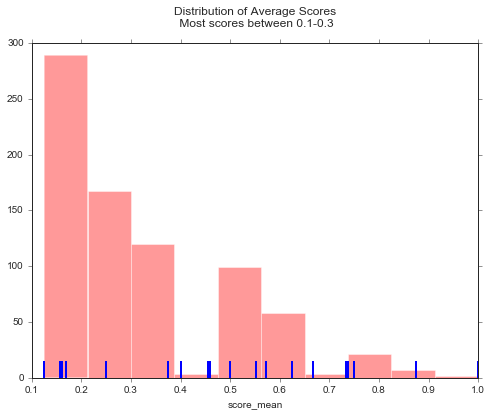

In [36]:
# plot distribution of scores 
fig, ax = plt.subplots(figsize = (8,6))
_ = sns.distplot(word_stats.score_mean, bins = 10, ax = ax, rug=True, hist=True, kde=False,
             hist_kws={'color':'red','stacked':True},
             rug_kws={'color':'blue','lw':2} )
ax.set_title('Distribution of Average Scores\n Most scores between 0.1-0.3\n')
plt.show(fig)

In [37]:
word_stats.sort_values('score_counts', ascending=False).head()

,score_counts,score_mean
imp_words,,
justice,641,0.250
section,240,0.125
new,211,0.375
contact,200,0.375
conduct,179,0.250


In [38]:
bins = np.arange(0, 800, 50)
# word_stats['count_range'] = pd.cut(word_stats.score_counts, bins=bins, include_lowest=False)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]


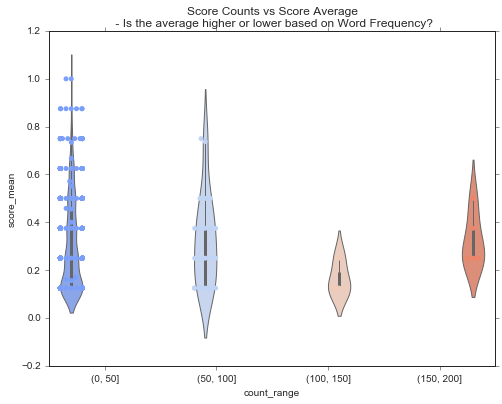

In [39]:
temp = word_stats.loc[word_stats.score_counts<250]
bins = np.arange(0, 250, 50)
temp['count_range'] = pd.cut(temp.score_counts, bins=bins, include_lowest=False)

# plot violinplot of counts vs score_mean
fig, ax = plt.subplots(figsize = (8,6))
sns.violinplot(ax=ax, x = 'count_range', y = 'score_mean', hue = "count_range",
               data=temp, palette="coolwarm")
# plot datapoints on top in shape of swarmplot of counts vs score_mean
sns.swarmplot(ax=ax, x = 'count_range', y = 'score_mean', hue = "count_range",data=temp,split=True, 
              palette="coolwarm")
# turn off legend
ax.legend().set_visible(False)
ax.set_title('Score Counts vs Score Average\n - Is the average higher or lower based on Word Frequency?')
plt.show(fig)

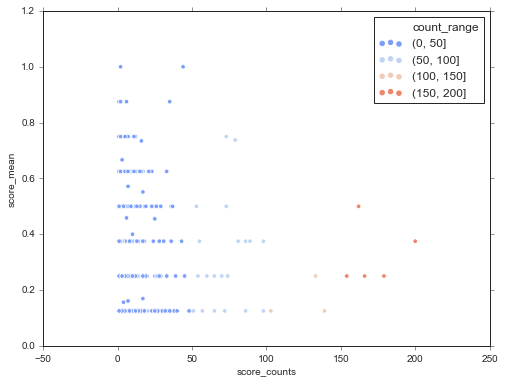

In [40]:
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data = temp, x = "score_counts", y = "score_mean", 
                ax = ax, palette="coolwarm", hue = "count_range")
ax.legend(loc = 'upper right')
plt.show(fig)

In [42]:
# most positive words - scores between 0.7 - 1.0
temp2 = word_stats[(word_stats.score_mean >.70) & (word_stats.score_mean<=1.0)]
temp2 = temp2.sort_values(by = 'score_mean', ascending=False).reset_index()[:21]
temp2.set_index('imp_words', inplace=True)
temp2

,score_counts,score_mean
imp_words,,
praise,2,1.000
investigator,44,1.000
reserve,1,0.875
prefer,2,0.875
legendary,1,0.875
important,35,0.875
nice,1,0.875
respected,2,0.875
happy,6,0.875


In [48]:
# most negative words - scores between 0.1 - 0.3
temp3 = word_stats[(word_stats.score_mean >0.01) & ((word_stats.score_mean <=0.2))]
temp3 = temp3.sort_values(by = 'score_mean', ascending=False).reset_index()[:21]
temp3.set_index('imp_words', inplace=True)
temp3

,score_counts,score_mean
imp_words,,
test,17,0.169118
favor,7,0.160714
routine,4,0.156250
peace,16,0.125000
practical,1,0.125000
popular,5,0.125000
playboy,2,0.125000
permission,1,0.125000
performance,13,0.125000


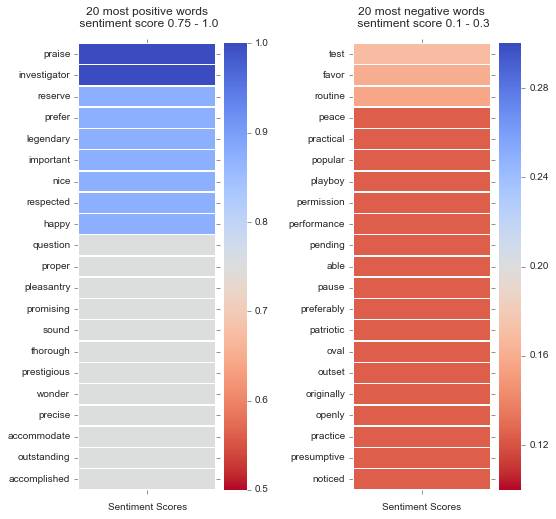

In [44]:
# heatmap of scores >0.5
fig, axes = plt.subplots(figsize = (8,8), ncols=2)
_= sns.heatmap(temp2[['score_mean']], vmax=1.0, vmin=.5, linewidths=.5, linecolor ='white',
            cmap="coolwarm_r", ax=axes[0])
_= sns.heatmap(temp3[['score_mean']], vmax=0.3, vmin=0.1, linewidths=.5, linecolor ='white',
            cmap="coolwarm_r", ax=axes[1])
axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[0].set_xlabel("Sentiment Scores")
axes[1].set_xlabel("Sentiment Scores")
axes[0].set_xticklabels("")
axes[1].set_xticklabels("")

# adjust spacing between plots 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=None)

axes[0].set_title('20 most positive words\n sentiment score 0.75 - 1.0\n')
axes[1].set_title('20 most negative words\n sentiment score 0.1 - 0.3\n')
plt.show(fig)

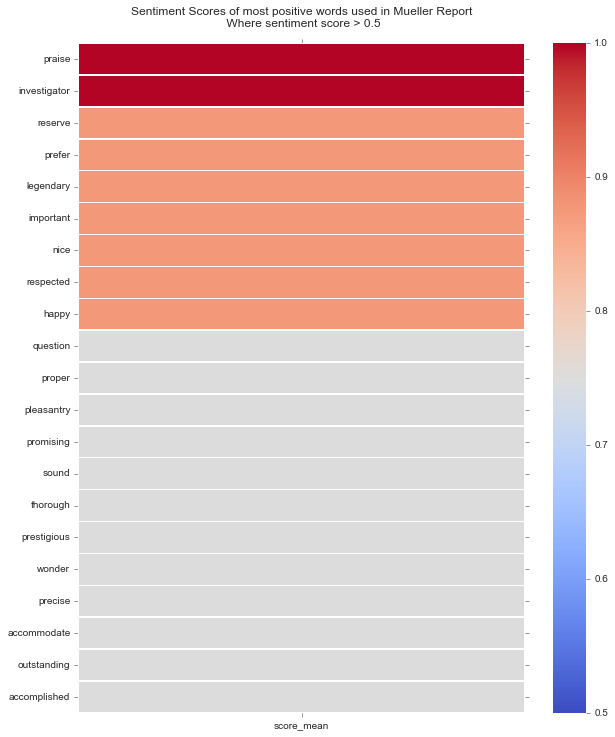

In [45]:
# heatmap of scores >0.5
fig, ax = plt.subplots(figsize = (10,12))
_= sns.heatmap(temp2[['score_mean']], vmax=1.0, vmin=.5, linewidths=.5, linecolor ='white',
            cmap="coolwarm")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Sentiment Scores of most positive words used in Mueller Report\n Where sentiment score > 0.5\n')
plt.show(fig)

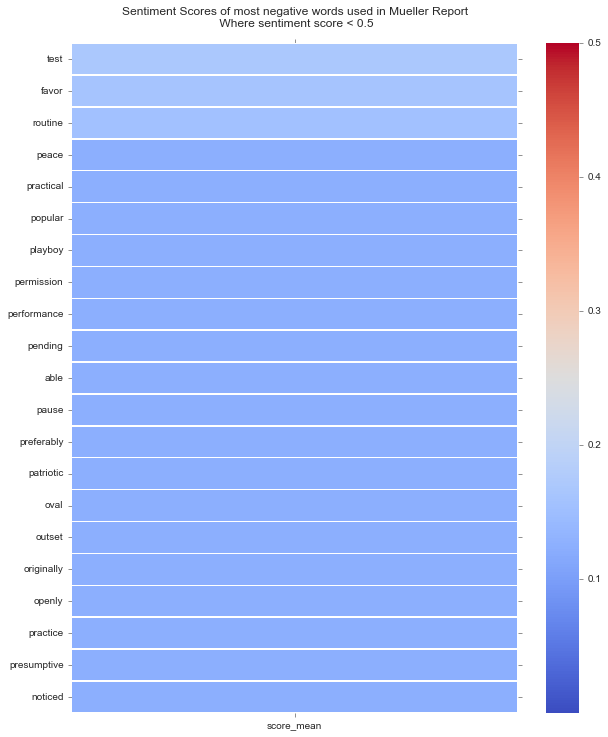

In [47]:
# heatmap of scores <0.5
fig, ax = plt.subplots(figsize = (10,12))
_= sns.heatmap(temp3[['score_mean']], vmax=0.5, vmin=0.0001, linewidths=.5, linecolor ='white',
               cmap="coolwarm")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Sentiment Scores of most negative words used in Mueller Report\n Where sentiment score < 0.5\n')
plt.show(fig)

In [ ]:
## next steps: document in github